# Analysis of football match statistics and outcomes

## Initial Aims for exploration:
- Import all matches from 2008 - 2016 including data on:
    - Teams involved
    - Match Outcome
    - Match Stats e.g. shots, possession, bookings etc
    - ID of the players in the match day starting 11 plus their ability ratings
    - Other info that can be engineered that I feel is relevant to match outcome

- MVP: Build a model for match prediction for English Premier League games - based on the team stats e.g. avg goals per game, ratings of players in the starting 11

- Stretch 1 - is the style of win changing (2008 - 2011 Tiki Taka in the ascendancy on the continent; 2013- gegenpressing in Germany). Do the match stats show a difference in manner of victory?

The database is in SQL so we'll use SQLite to bring it in and do some initial analysis on a few tables

In [22]:
# imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings

warnings.simplefilter('ignore') # this is to ignore warnings that are not useful

### What is in this database?

There are seven SQL tables available. Reading from the Kaggle Data Card:

- **Country**: We will take England only for the MVP (country id 1729) and we'll use this to join up the English Premier League Matches in the Match table

- **League**: The top tier league in all of the countries in Country are here. 
    - Includes Spain, France, Italy and Germany (with England they make up the top 5 European Leagues) and Scotland among others. We are beginning with just England (league id 1729 like the country id)

- **Match**: 26,000 rows with country id and league id. Other columns include:
    - stage, which presumably is the round in the season e.g. in a 20-team home-and-away season of 38 games, stage 1 is the opening round and 38 is the final game day. Easy to audit this - England is 20 teams and there should be exactly 38 stages in every season

    - Home team and away team identifiers; 

    - home goals & away goals
    
    - **home and away players X and Y coordinates.** I think this is their average position. From just eyeballing this, 1 is the goalkeeper and this is very narrowly defined (because goalkeepers don't move much compared to other positions). It's missing for about 7% of records, probably the earlier seasons in some leagues before it was recorded

    - Key match stats, but data appears to be missing for 45% of records (according to the Kaggle data card):
        - Goals
        - Shot on target
        - shot off target
        - foul committed
        - cards
        - crosses
        - corner
        - possession
    
     
    - Bet 365 odds (B365H / B365D / B365A) - ignore for now, we are trying to do our own and could compare to these *later*
        - Lots of other columns which are for betting providers too. We can ignore for now 
            - BWH, BWD, BWA, 
            - IWH, IWD, IWA, 
            - LBH, LBD, LBA... These all have Home, Draw, Away and I think they are all bookmaker stats

- **Player** - Basic info like DOB, Height, Weight

- **Player_Attributes** - more detailed stats like overall_rating, potential, pref. foot, work rates, crossing, finishing etc. This information is provided from the FIFA video games which gives every player a measure of ability

- **Team** - Very basic identifying info like Name & id for link to other tables

- **Team_Attributes** - more detail around build up play statistics and it is recorded once per year. Also comes from FIFA data
    - is it changing over time?

## What Questions can we answer with a predictive model?

### 1. MVP: Can we predict match outcome? Data columns could include
- **Home & away team,** result which we engineer from home goals & away goals, with winning team id
- **OVR Rating of the starting 11**, coming from Player_attributes via player_api_id.
    - Start with avg OVR rating. Then maybe add OVR rating for Strikers, Goalkeeepers
    
- **For more granular data**, bring in players' work rates, GK overall, overall finishing stats.
    - NOTE: there is no data column for player position. There are too many to label manually, so we could implement a rule based on some of the key player stats to identify this. BY far the easiest will be goalkeeper, and we add OVR rating for that.
    - ANy other granular data for the most likely stats to impact goals scored/conceded, because that's the direct influence on the results


### 2. Stretches  - once we have done the MVP

- How does Height/Weight affect style of play? Taller, bulkier players mean a faster long-ball style of play?

-  Physical vs Technical - which ability set is more important in the winning teams?
    - Physical: Acceleration, Sprint Speed, Agility, Reactions, Balance, Jumping, Stamina, Strength
    - Technical: Crossing, Finishing, Heading Acc., Short Passing, Volleys, Dribbling, Curve, FK Acc., Long Passing, Ball Control
    - Mental: Aggression, Interceptions, Positioning, Vision, Penalties (it's psychological)



## Open the database (pandas)

In [23]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    all_countries = pd.read_sql_query("SELECT * from Country", conn)
    all_matches = pd.read_sql_query("SELECT * from Match", conn)
    all_leagues = pd.read_sql_query("SELECT * from League", conn)
    all_teams = pd.read_sql_query("SELECT * from Team", conn)

    # get matches from outside England (league id 1729) for a base rate W/D/L comparison
    european_matches = pd.read_sql_query("SELECT * FROM Match WHERE league_id != 1729", conn)

In [24]:
all_teams.sample(5) # we want to use team_long_name and bring that into the matches dataframe

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
235,39388,8548,86.0,Rangers,RAN
17,18,9986,670.0,Sporting Charleroi,CHA
15,16,9996,111560.0,Royal Excel Mouscron,MOU
31,3463,8654,19.0,West Ham United,WHU
261,43045,9869,459.0,Real Sporting de Gijón,SPG


In [25]:
selected_countries = ['England'] # leave this format in case we want to add more countries later
countries = all_countries[all_countries.name.isin(selected_countries)] # England id is 1729

# merge leagues - it is only going to be premier league, but incase other leagues are added in the future
leagues = countries.merge(all_leagues, on='id', suffixes=('', '_y')) # suffixes = ('', '_y') is to avoid duplicate columns


In [26]:
# checking that English matches have been removed properly
print(european_matches.shape)
print(all_matches.shape)

(22939, 115)
(25979, 115)


In [27]:
# check all columns - more exploration done above and we will remove all the bookies columns soon
all_matches.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [28]:
matches_prem = all_matches[all_matches.league_id.isin(leagues.id)] 
# Above, we could do league_id == 1729, but this is more flexible when we decide to add more leagues,
# We just add the country name two code cells above and it will work

Below I will **remove the bookmakers odds columns** - they begin with Bet 365 (B365X, where X = H for a bet on the Home team winning; D for Draw, A for Away team, and have many outlets inc. Ladbrookes (LBX), Bet Victor (VCX), William Hill (WHX)) so I will cut off the matches df from the Bet 365 columns onwards.

In [29]:
# 86th column is B365H - remove everything from here onward
matches_prem = matches_prem.iloc[:, :85]

## Initial Data Cleaning & Exploratory Data Analysis (EDA) in Pandas

Initial Look after betting odds columns have been removed:

In [30]:
matches_prem.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,24635.0,30853.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,127857.0,34466.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,33633.0,107216.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...


Add team names

In [31]:
# Merge the home team name
matches_prem = matches_prem.merge(
    all_teams[['team_api_id', 'team_long_name']],
    how='left',
    left_on='home_team_api_id',
    right_on='team_api_id'
).rename(columns={'team_long_name': 'home_team'})

# Drop the redundant team_api_id column (if necessary)
matches_prem = matches_prem.drop(columns=['team_api_id'])

# Merge the away team name
matches_prem = matches_prem.merge(
    all_teams[['team_api_id', 'team_long_name']],
    how='left',
    left_on='away_team_api_id',
    right_on='team_api_id'
).rename(columns={'team_long_name': 'away_team'})

# Drop the redundant team_api_id column (if necessary)
matches_prem = matches_prem.drop(columns=['team_api_id'])

# Preview the result
print(matches_prem[['home_team_api_id', 'home_team', 'away_team_api_id', 'away_team']].head())


   home_team_api_id          home_team  away_team_api_id             away_team
0             10260  Manchester United             10261      Newcastle United
1              9825            Arsenal              8659  West Bromwich Albion
2              8472         Sunderland              8650             Liverpool
3              8654    West Ham United              8528        Wigan Athletic
4             10252        Aston Villa              8456       Manchester City


### Comments for initial cleaning & EDA
- Stripping out unnecessary ID columns
- Renaming and reordering columns for clarity and ease of reading
- casting to appropriate data type

Notes for cleaning

- We don't need the country_id and league_id when we know all of these are Premier League games for the MVP. We can remove these columns, keep the id as the index column.

- We can clean the other columns so it is readable e.g. the match stats look like they've been scraped from HTML. We can parse and extract the important stuff like goals.

- Maybe later, we will feature engineer for last five results to show recent form going into this game (date will be important)

- For prediction, the **base rate** is important. Before we introduce any specific team information at all, how often do Home wins, draws or away wins occur? we should look at all leagues for a solid base rate not just England

In [32]:
# make a prem df where we drop the country_id and league_id columns
prem = matches_prem.drop(['country_id', 'league_id'], axis=1)

In [33]:
# rename columns to make them more understandable

# rename stage to round / 38 rounds in a premier league season
prem = prem.rename(columns={'stage': 'Gameweek / 38'})

# rename values in season - split the season before and after the / and take the last two characters of both
prem['season'] = prem['season'].apply(lambda x: x.split('/')[0][2:] + '/' + x.split('/')[1][2:])

prem = prem.rename(columns={'home_team_goal': 'Home GS', 'away_team_goal': 'Away GS', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

# the same for all_matches
european_matches = european_matches.rename(columns={'home_team_goal': 'Home GS', 'away_team_goal': 'Away GS', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

# cast the date column to datetime
prem['date'] = pd.to_datetime(prem['date'])

For now we won't use the X and Y coordinates of the players so we will remove those columns

In [34]:
# remove player coordinates more concisely
prem = prem[prem.columns.drop(list(prem.filter(regex='(home|away)_player_(X|Y)[1-9]|(home|away)_player_(X|Y)10|(home|away)_player_(X|Y)11')))]

# cast home_player_1 to home_player_11 to int
# Use a combined regex to match and cast both 'home_player_1' to 'home_player_11' and 'away_player_1' to 'away_player_11' to Int64
prem[prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').columns] = \
    prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').astype('Int64')

In [35]:
# insert the home and away team names at the start of the df, after date and before the rest of the columns
prem = prem[['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS', 'Away GS', 'away_team'] + [col for col in prem.columns if col not in ['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS', 'Away GS', 'away_team']]]

In [36]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,match_api_id,Home ID,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1447,3176,11/12,2012-05-06,37,Newcastle United,0,2,Manchester City,1026141,10261,...,26181,37412,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
251,1980,08/09,2009-04-11,32,Sunderland,1,2,Manchester United,489354,8472,...,27430,38817,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><event...
2225,3954,13/14,2013-09-15,4,Southampton,0,0,West Ham United,1474180,8466,...,23538,91560,<goal />,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>63</comment><event...
2658,4387,14/15,2014-10-25,9,West Bromwich Albion,2,2,Crystal Palace,1724070,8659,...,25537,24157,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>64</comment><event...
2247,3976,13/14,2013-09-29,6,Sunderland,1,3,Liverpool,1474219,8472,...,51553,106228,<goal><value><comment>n</comment><stats><goals...,<shoton><value><event_incident_typefk>157</eve...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...


In [37]:
prem.columns

Index(['id', 'season', 'date', 'Gameweek / 38', 'home_team', 'Home GS',
       'Away GS', 'away_team', 'match_api_id', 'Home ID', 'Away ID',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1',
       'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
       'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9',
       'away_player_10', 'away_player_11', 'goal', 'shoton', 'shotoff',
       'foulcommit', 'card', 'cross', 'corner', 'possession'],
      dtype='object')

Add a Result column below - positive for home win (+3 means 3 goal victory), 0 for draw, negative for away win

In [38]:
# add the Result Column - 1 if home team wins, 0 if draw, -1 if away team wins
prem.insert(9, 'Result', np.sign(prem['Home GS'] - prem['Away GS']))

# add the Margin column = gives the margin of victory for the home / away team
prem.insert(10, 'Margin', prem['Home GS'] - prem['Away GS'])

# same with the all_matches table
european_matches.insert(8, 'Result', np.sign(european_matches['Home GS'] - european_matches['Away GS']))

european_matches.insert(9, 'Margin', european_matches['Home GS'] - european_matches['Away GS'])

In [39]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,match_api_id,Result,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
331,2060,08/09,2008-09-20,5,Sunderland,2,0,Middlesbrough,489083,1,...,24159,35608,<goal><value><comment>npm</comment><event_inci...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>52</comment><elaps...
1221,2950,11/12,2011-12-22,17,Tottenham Hotspur,1,1,Chelsea,1025023,0,...,30822,41468,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>78</comment><event...
1590,3319,12/13,2012-12-08,16,Arsenal,2,0,West Bromwich Albion,1229261,1,...,25550,23293,<goal><value><comment>p</comment><stats><penal...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>59</comment><event...
1820,3549,12/13,2013-05-14,37,Arsenal,4,1,Wigan Athletic,1229493,1,...,30922,41061,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>69</comment><event...
176,1905,08/09,2009-02-07,25,West Bromwich Albion,2,3,Newcastle United,489289,-1,...,24225,36412,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>46</comment><event...


In [40]:
# drop match_api_id column
prem = prem.drop('match_api_id', axis=1)

### Establishing a Base Rate prediction for Home Win, Draw, Away Win
- what are the high level statistics on frequency of home win, draw and away win that could serve as Bayesian priors?

So far we have made the results and margin columns, which indicate 1 for a home win, 0 for draw and -1 for home loss.

I think we can make a 'base rate' that the model could in future use to predict a result. Let's get some visuals on a very large level how common home vs away wins are.

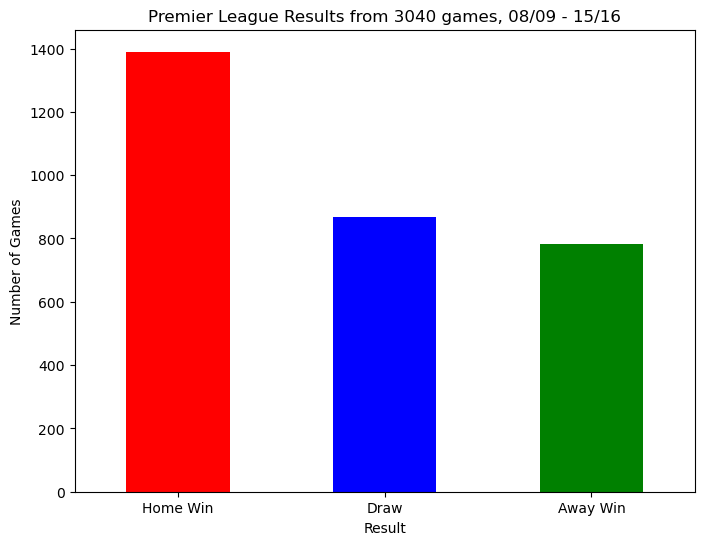

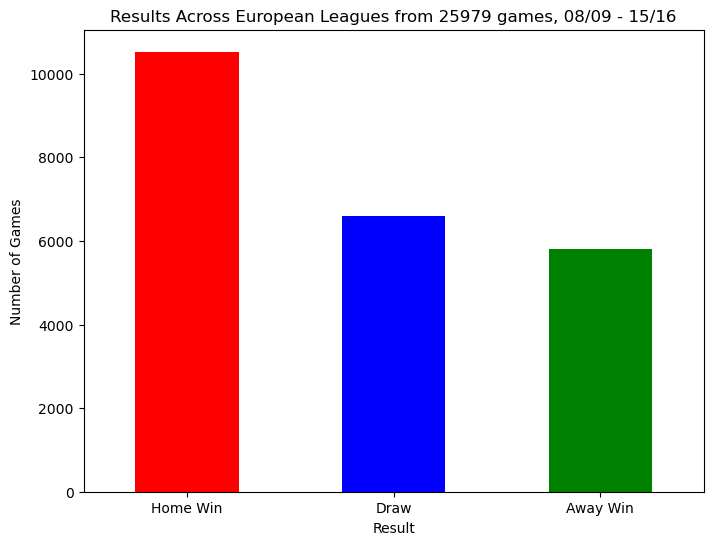

In [41]:
import matplotlib.pyplot as plt

# First figure for the 'prem' dataframe
plt.figure(figsize=(8, 6))
prem['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
plt.ylabel('Number of Games')
plt.title('Premier League Results from 3040 games, 08/09 - 15/16')
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(8, 6))
european_matches['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
# label y axis with total number of games - 25979
plt.ylabel('Number of Games')

# title - Results Across European Leagues from 25979 games, 08/09 - 15/16
plt.title('Results Across European Leagues from 25979 games, 08/09 - 15/16')
plt.show()


In [42]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Count the number of occurrences of each result for 'prem'
prem_result_counts = prem['Result'].value_counts()
prem_labels = ['Home Win', 'Draw', 'Away Win']
prem_values = [prem_result_counts[1], prem_result_counts[0], prem_result_counts[-1]]

# Count the number of occurrences of each result for 'all_matches'
european_matches_result_counts = european_matches['Result'].value_counts()
european_matches_labels = ['Home Win', 'Draw', 'Away Win']
european_matches_values = [european_matches_result_counts[1], european_matches_result_counts[0], european_matches_result_counts[-1]]

# Create a subplot figure with two pie charts
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=[
    'Premier League Results, 3040 games, 08/09 - 15/16',
    'Europe (non-PL) Results, 22939 games, 08/09 - 15/16'
])

# Add the first pie chart (for 'prem')
fig.add_trace(
    go.Pie(
        labels=prem_labels,
        values=prem_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=1
)

# Add the second pie chart (for 'all_matches')
fig.add_trace(
    go.Pie(
        labels=european_matches_labels,
        values=european_matches_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=2
)

# Update the layout of the figure
fig.update_layout(title_text='Comparison of Match Results in England and rest of Europe', title_x=0.5)

# Show the figure
fig.show()


So we can see that Home Win is the most common result by far, almost twice as common as a draw and also far more likely than an Away Win.

These results in England and Europe are remarkably similar across tens of thousands of games in ten years. 

These are strong base rates. I will add these ad columns in the Prem dataframe for the model to see.

In [43]:
# add three columns - P(Home), P(Draw), P(Away) - the probability of each result
prem.insert(11, 'p(Home)', 0.457)
prem.insert(12, 'p(Draw)', 0.258)
prem.insert(13, 'p(Away)', 0.285)

Now we can compare the Margins - how are these distributed? What are specifically the most common results?

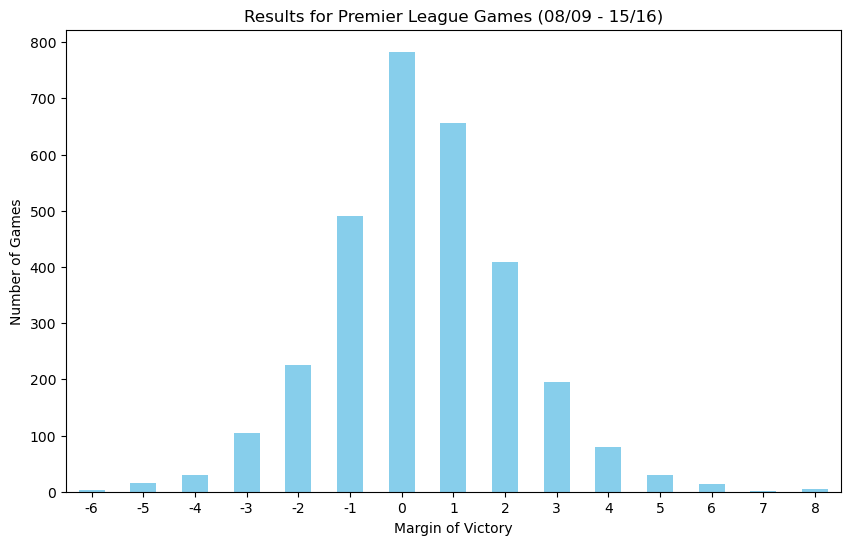

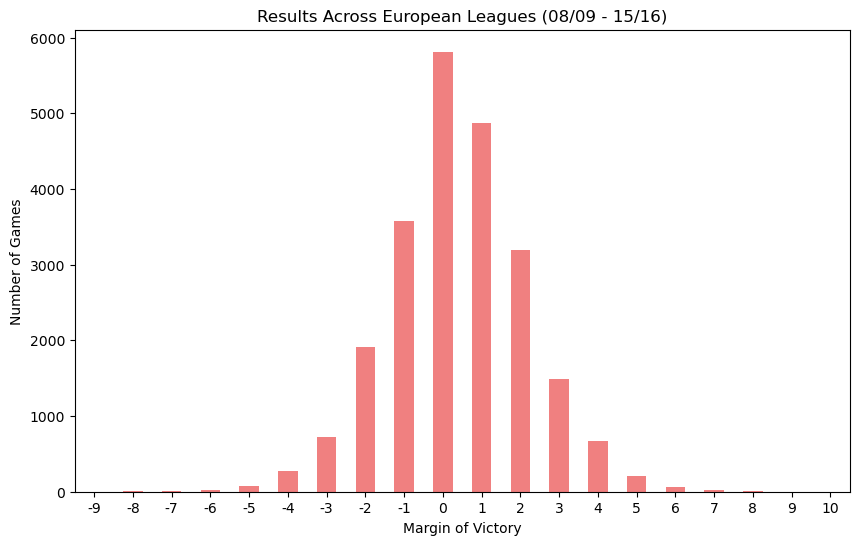

In [44]:
# First figure for the 'prem' dataframe
plt.figure(figsize=(10, 6))
prem['Margin'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results for Premier League Games (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(10, 6))
european_matches['Margin'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results Across European Leagues (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()


Again, the results are remarkably similar! Bear in mind that 0 here represents *all draws*, not a 0-0 draw which is how all games begin, so the tendency of a home win by 1 goal is still quite close in frequency.

We will want to tease out 0-0 draws from 1-1 draws if we want to predict the Margin later on, but that is a Stretch goal.

For now, the previous few cells show that a Home Win is nearly twice as frequent as any other result with remarkable consistency across different European football leagues.

**Base Rates**
- Home Win: ~46%
- Away Win: ~28.5%
- Draw: ~ 25.5%

### Frequency of individual results (e.g. 1-0, 2-2, 0-2)
- A home win is the most common general outcome, but which specific scorelines do we see the most? 
- If the match starts at 0-0, how common are specific draw scorelines?

In [45]:
# count every unique combination of home goals vs away goals
prem_goals = prem.groupby(['Home GS', 'Away GS']).size().reset_index(name='Count')
european_matches_goals = european_matches.groupby(['Home GS', 'Away GS']).size().reset_index(name='Count')
prem_goals.head(10)

,Home GS,Away GS,Count
0,0,0,251
1,0,1,213
2,0,2,120
3,0,3,72
4,0,4,23
5,0,5,11
6,0,6,3
7,1,0,308
8,1,1,317
9,1,2,205


In [46]:
# create "Final Score" column to show the result of the match
prem_goals['Final Score'] = prem_goals['Home GS'].astype(str) + ' - ' + prem_goals['Away GS'].astype(str)
european_matches_goals['Final Score'] = european_matches_goals['Home GS'].astype(str) + ' - ' + european_matches_goals['Away GS'].astype(str)

In [47]:
prem_goals[['Home GS', 'Away GS', 'Final Score', 'Count']].sample(5)

,Home GS,Away GS,Final Score,Count
38,6,0,6 - 0,9
44,7,2,7 - 2,1
15,2,1,2 - 1,269
18,2,4,2 - 4,13
22,3,2,3 - 2,68


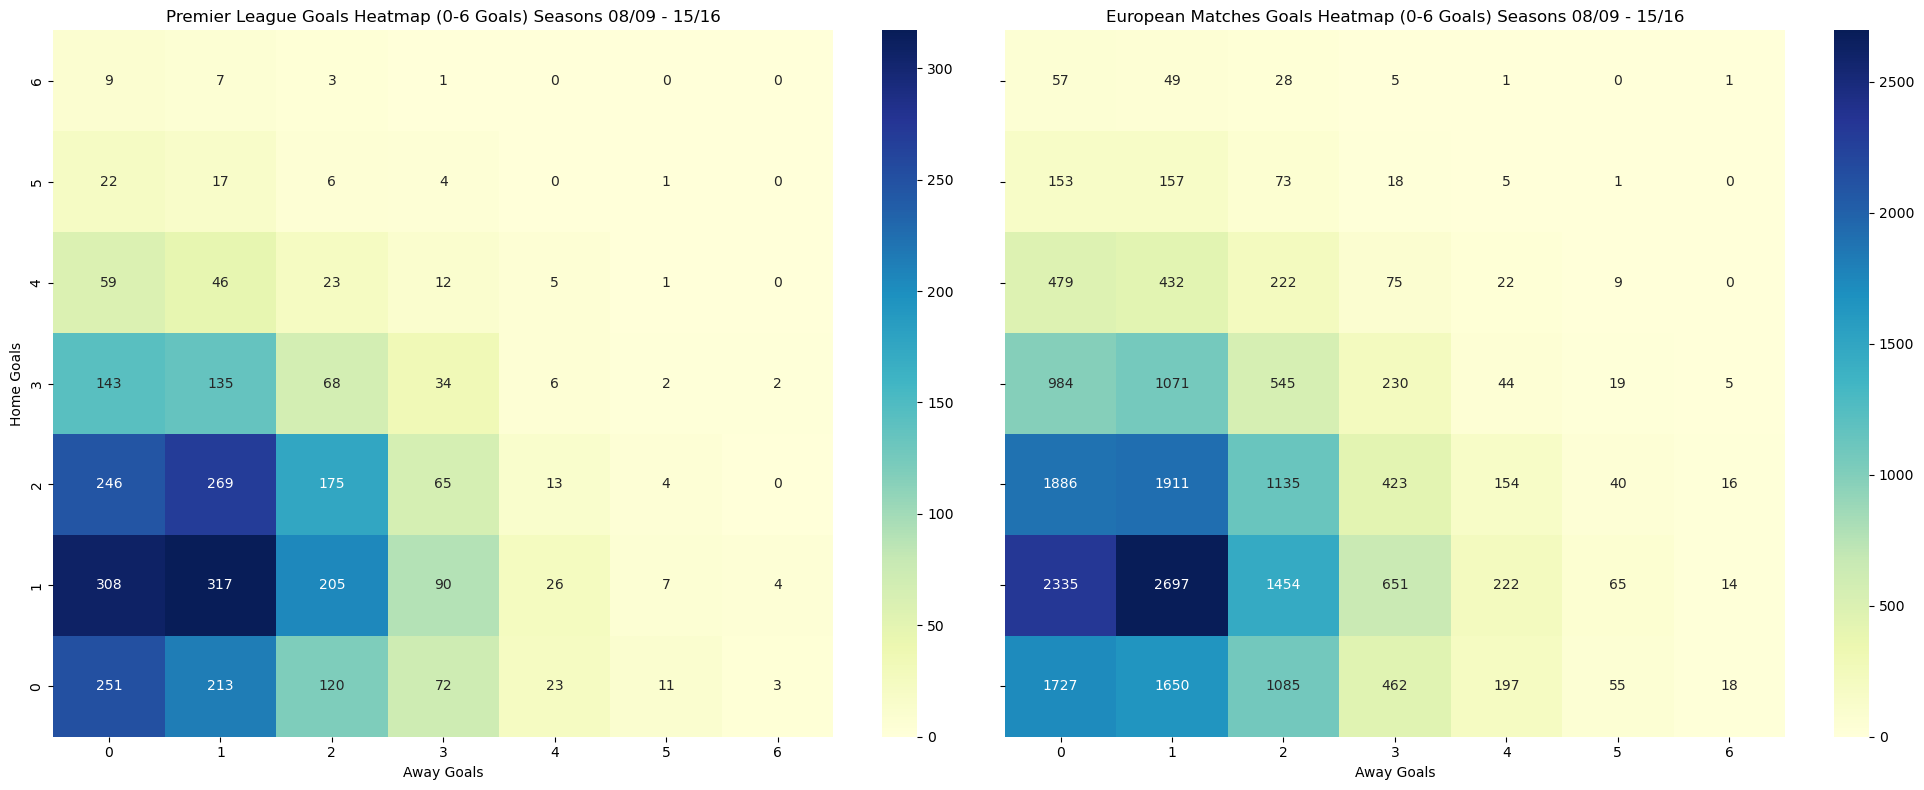

In [48]:
import numpy as np

# Define the range for Home GS and Away GS
goal_range = np.arange(0, 7)  # From 0 to 6 inclusive

# Filter the Premier League matrix to include only 0-6 goals
fixture_matrix = (
    prem_goals.pivot_table(
        index='Home GS',
        columns='Away GS',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Filter the European Matches matrix to include only 0-6 goals
european_fixture_matrix = (
    european_matches_goals.pivot_table(
        index='Home GS',
        columns='Away GS',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Reverse the order of rows and columns for both matrices to align (0, 0) in the bottom-left corner
fixture_matrix = fixture_matrix.iloc[::-1]
european_fixture_matrix = european_fixture_matrix.iloc[::-1]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Heatmap for Premier League
sns.heatmap(
    fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[0]
)
axes[0].set_title('Premier League Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16')
axes[0].set_xlabel('Away Goals')
axes[0].set_ylabel('Home Goals')

# Heatmap for European Matches
sns.heatmap(
    european_fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[1]
)
axes[1].set_title('European Matches Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16')
axes[1].set_xlabel('Away Goals')
axes[1].set_ylabel('')  # No y-label on the second plot to avoid redundancy

# Adjust layout
plt.tight_layout()
plt.show()

so 1-1 is the most likely individual score followed by 1-0 (very closely in both!) and from eyeballing this, the % of results are also eerily close for both. 1-0 is a couple of percentage points behind 1-1 in both.

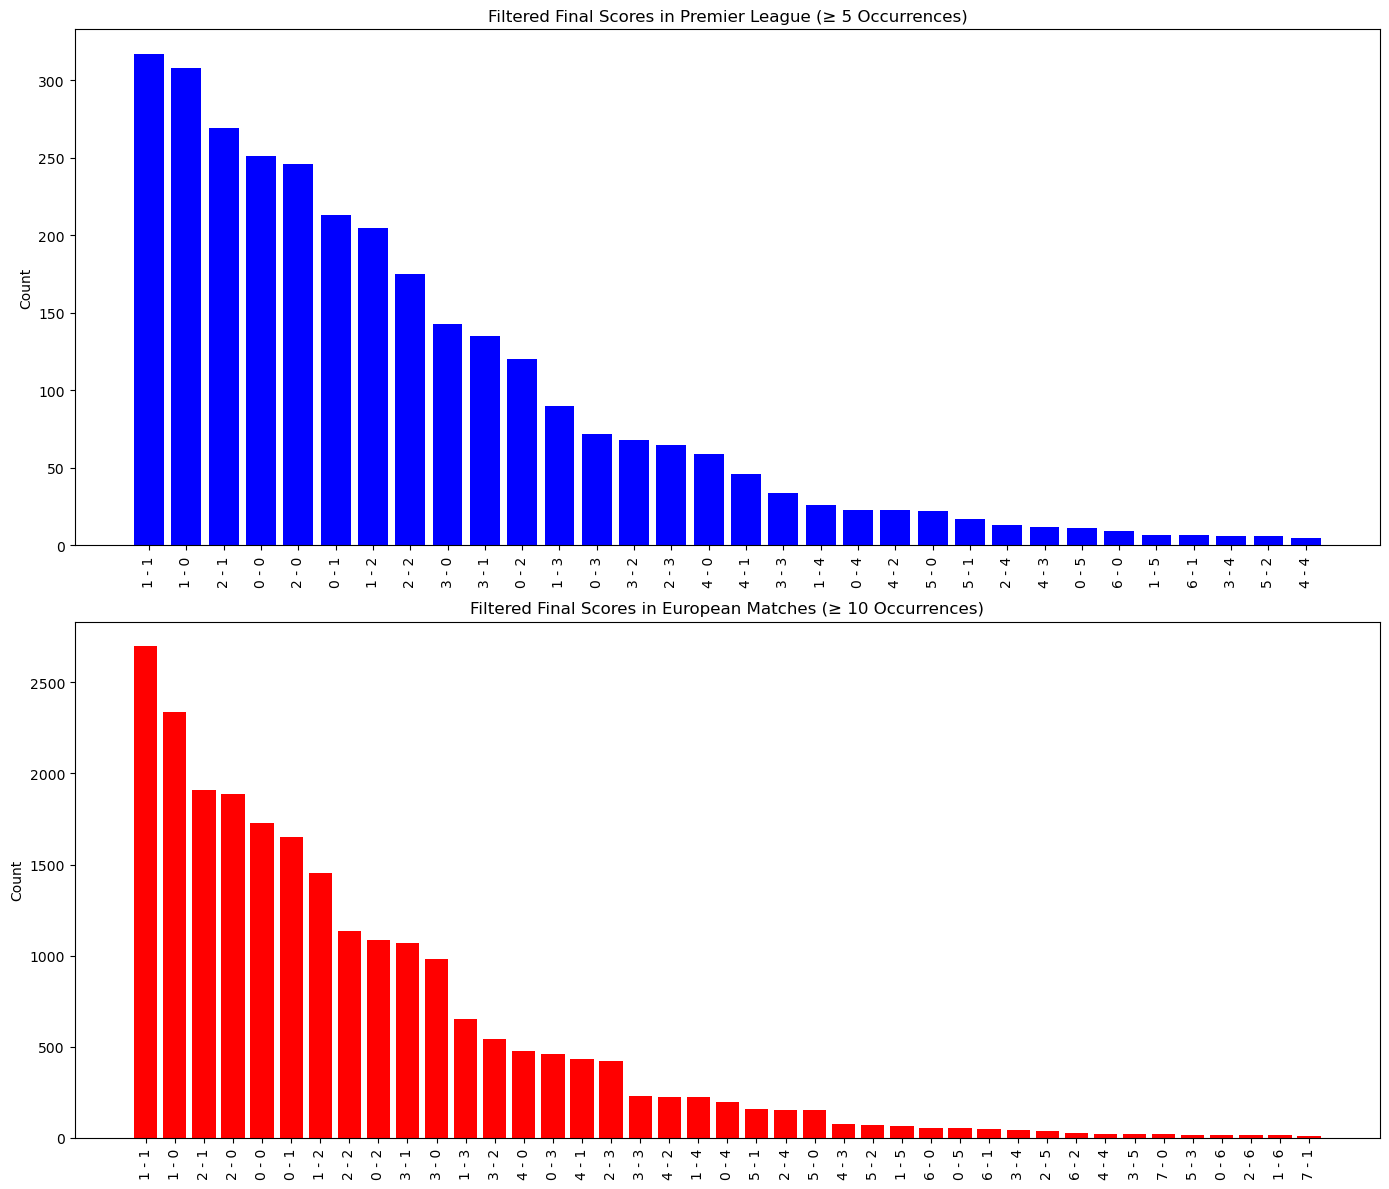

In [49]:
# Filter and sort the Premier League data - trim out the very rare scores
prem_filtered = prem_goals[prem_goals['Count'] >= 5].sort_values(by='Count', ascending=False)

# Filter and sort the European Matches data - trim out the very rare scores
european_filtered = european_matches_goals[european_matches_goals['Count'] >= 10].sort_values(by='Count', ascending=False)

# Create subplots for the filtered bar charts
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Bar chart for Premier League
axes[0].bar(prem_filtered['Final Score'], prem_filtered['Count'], color='blue')
axes[0].set_title('Filtered Final Scores in Premier League (≥ 5 Occurrences)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Bar chart for European Matches
axes[1].bar(european_filtered['Final Score'], european_filtered['Count'], color='red')
axes[1].set_title('Filtered Final Scores in European Matches (≥ 10 Occurrences)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Some differences starting to emerge now - but 1-1, 1-0 and 2-1 still in order the most common results! 0-0 and 2-0 are reversed in Europe and the Prem, but then 0-1, 1-2 and 2-2 are the next most frequent scores in both datasets.

Let's get a % pie chart for the results

In [50]:
import plotly.express as px

# Calculate total matches for each dataset
prem_total = prem_goals['Count'].sum()
european_total = european_matches_goals['Count'].sum()

# Filter and group results for Premier League
prem_goals['Percentage'] = prem_goals['Count'] / prem_total * 100
prem_filtered = prem_goals[prem_goals['Percentage'] >= 2]
prem_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [prem_goals[prem_goals['Percentage'] < 2]['Count'].sum()]
})
prem_pie_data = pd.concat([prem_filtered[['Final Score', 'Count']], prem_other])

# Filter and group results for European Matches
european_matches_goals['Percentage'] = european_matches_goals['Count'] / european_total * 100
european_filtered = european_matches_goals[european_matches_goals['Percentage'] >= 2]
european_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [european_matches_goals[european_matches_goals['Percentage'] < 2]['Count'].sum()]
})
european_pie_data = pd.concat([european_filtered[['Final Score', 'Count']], european_other])

# Pie chart for Premier League Final Scores
prem_pie = px.pie(
    prem_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 3,000 Premier League matches? (08/09 - 15/16)',
    hole=0.3
)
prem_pie.update_traces(textinfo='label+percent', textposition='outside')
prem_pie.show()

# Pie chart for European Matches Final Scores
european_pie = px.pie(
    european_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 22,000 European league matches? (08/09 - 15/16)',
    hole=0.3
)
european_pie.update_traces(textinfo='label+percent', textposition='outside')
european_pie.show()

#### Observations
- The frequency of results across these leagues is staggering! Many individual results are only a single percentage point off each other at most
- Many results are in the same order with less than a quarter of a percentage point off in frequency is very interesting. These give a good base rate of longer term trends we can see.
    - Perhaps later we'll check out if these base rates are changing over time (is home field advantage decreasing over time, for instance?)
- 1-1 is the most common result and in the larger European sample, it is even more so than the PL. 1-0 is next, followed by 2-1 about 1.5 percent down which is close by with 2-0. 
- 0-0 draws are the fourth (PL) or fifth (Europe) most common result and a little bit more frequent in the Premier League.

#### Statistics of higher scoring teams in games

- Another interesting observation here is how rare instances of teams scoring three goals in a game are. The most common instance of one team scoring 3 goals is 4.3 - 4.7%, with 3-0 and 3-1 to the home team, followed by 3-2 (2.38%)

From anecdotal / personal observations of the best teams that are capable of scoring 3 goals in a game consistently, and the tendency to create cagey matches when they play each other, I'd like to explore the teams that frequently score 3+ goals in a game and their number of draws.

### EDA of Specific results and teams
- Can we learn patterns in the teams involved in high scoring (3+ for an individual team) games?
- Does playing at home or away affect the teams that happen to score 3+ in a match?
- Can team's data around scoring and conceding 3 goals, a rare occurrence, enhance our away win predictions down the line?

Coming back after my first run of the model, I need to solve the model's ability to predict draws and be better at predicting away wins.

When I saw that 3-0 or 3-1 only occurs around 4.5% of the time in the section above, and it is one of the less common results, I thought there would be potential to pick out the 'top teams' that would be more favourable for away wins, which are the ones that more frequently score 3 goals in a single match. These are the teams with the ability to easily win their home games and an attritional low-quality match, which would be a draw for most teams, would more likely be a win for them.

In [133]:
# how many matches has every unique team played in the premier league
home_team_counts = prem['home_team'].value_counts()

away_team_counts = prem['away_team'].value_counts()
appearances = home_team_counts.add(away_team_counts, fill_value=0).sort_values(ascending=False)
appearances.sample(5)

Bolton Wanderers    152
Crystal Palace      114
Chelsea             304
West Ham United     266
Newcastle United    266
Name: count, dtype: int64

In [134]:
# find the value counts for each team for matches where the home team has scored 3 or more goals
home_3_gs = prem[prem['Home GS'] >= 3]['home_team'].value_counts()
home_3_gs.sample(5)

home_team
Sunderland        20
Watford            2
Burnley            2
Cardiff City       3
Crystal Palace     6
Name: count, dtype: int64

In [135]:
away_3_gs = prem[prem['Away GS'] >= 3]['away_team'].value_counts()
away_3_gs.sample(5)

away_team
Blackpool           2
Cardiff City        1
Hull City           5
Southampton         8
Manchester City    34
Name: count, dtype: int64

I also want to see the porous teams - who is vulnerable at home and away?

In [136]:
home_3_ga = prem[prem['Away GS'] >= 3]['home_team'].value_counts()
home_3_ga.sample(5)

home_team
Everton                17
Swansea City           14
Cardiff City            5
Bournemouth             6
Queens Park Rangers     7
Name: count, dtype: int64

In [137]:
away_3_ga = prem[prem['Home GS'] >= 3]['away_team'].value_counts()
away_3_ga.sample(5)

away_team
Leicester City      3
Crystal Palace      6
Chelsea            15
West Ham United    30
Stoke City         35
Name: count, dtype: int64

I ran the sample function to save scrolling but by removing .sample, you can see the full results.

From very high level you can see that teams just don't score 3+ goals away from home as much as at home. No surprises there. It looks like about twice as likely that a team will score 3+ at home than away, but some teams like Arsenal seem to be quite consistent in their tendency to produce these games (only a 20% dropoff away from home).

Let's check.

In [138]:
# Make a df with team name, appearances, home 3+ goals, away 3+ goals
three_goals = pd.DataFrame({
    'Appearances': appearances,
    'Home 3+ Goals': home_3_gs,
    'Away 3+ Goals': away_3_gs,
    'Home 3+ Goals Against': home_3_ga,
    'Away 3+ Goals Against': away_3_ga
})

In [139]:
# We'll create columns for the probability of scoring 3+ goals at home and away, dividing appearances by half
three_goals['p(Home 3+ Goals)'] = round(three_goals['Home 3+ Goals'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Away 3+ Goals)'] = round(three_goals['Away 3+ Goals'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Home 3+ Goals Against)'] = round(three_goals['Home 3+ Goals Against'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Away 3+ Goals Against)'] = round(three_goals['Away 3+ Goals Against'] / (three_goals['Appearances'] / 2), 3)

# fill na values with 0
three_goals = three_goals.fillna(0)

# make Home 3+ goals and Away 3+ goals integers
three_goals['Home 3+ Goals'] = three_goals['Home 3+ Goals'].astype(int)
three_goals['Away 3+ Goals'] = three_goals['Away 3+ Goals'].astype(int)
three_goals['Home 3+ Goals Against'] = three_goals['Home 3+ Goals Against'].astype(int)
three_goals['Away 3+ Goals Against'] = three_goals['Away 3+ Goals Against'].astype(int)

# Rename the Appearances column to seasons, and divide the values by 38 to get the number of seasons the team appeared in this period
three_goals = three_goals.rename(columns={'Appearances': 'Seasons'})
three_goals['Seasons'] = (three_goals['Seasons'] / 38)

In [140]:
# seasons column as int
three_goals['Seasons'] = three_goals['Seasons'].astype(int)

In [141]:
# just the teams with more than one season in the premier league
three_goals.sort_values(by='Seasons', ascending=False)

,Seasons,Home 3+ Goals,Away 3+ Goals,Home 3+ Goals Against,Away 3+ Goals Against,p(Home 3+ Goals),p(Away 3+ Goals),p(Home 3+ Goals Against),p(Away 3+ Goals Against)
Arsenal,8,50,39,10,20,0.329,0.257,0.066,0.132
Chelsea,8,46,38,13,15,0.303,0.250,0.086,0.099
Tottenham Hotspur,8,35,23,11,27,0.230,0.151,0.072,0.178
Sunderland,8,20,15,19,35,0.132,0.099,0.125,0.230
Stoke City,8,20,5,11,35,0.132,0.033,0.072,0.230
Aston Villa,8,20,12,17,39,0.132,0.079,0.112,0.257
Manchester City,8,69,34,13,15,0.454,0.224,0.086,0.099
Liverpool,8,48,38,7,29,0.316,0.250,0.046,0.191
Everton,8,34,20,17,19,0.224,0.132,0.112,0.125
Manchester United,8,60,35,10,16,0.395,0.230,0.066,0.105


I want to determine a few things here as I add these probability of 3 goals columns:
- The teams with less appearances (because they got relegated from the PL) still have lower probabilities of scoring 3+ goals
- the differential between home and away probability of 3 goals

I will do a correlation heatmap of the probabilities of 3+ goals home and away, with the appearances

In [142]:
# differential between home and away 3+ goals
three_goals['Difference GS'] = three_goals['p(Home 3+ Goals)'] - three_goals['p(Away 3+ Goals)']
three_goals['Difference GA'] = three_goals['p(Home 3+ Goals Against)'] - three_goals['p(Away 3+ Goals Against)']

In [143]:
three_goals.sample(10)

,Seasons,Home 3+ Goals,Away 3+ Goals,Home 3+ Goals Against,Away 3+ Goals Against,p(Home 3+ Goals),p(Away 3+ Goals),p(Home 3+ Goals Against),p(Away 3+ Goals Against),Difference GS,Difference GA
Fulham,6,19,8,20,22,0.167,0.070,0.175,0.193,0.097,-0.018
Reading,1,3,1,5,7,0.158,0.053,0.263,0.368,0.105,-0.105
Blackpool,1,2,2,7,8,0.105,0.105,0.368,0.421,0.000,-0.053
Crystal Palace,3,6,9,9,6,0.105,0.158,0.158,0.105,-0.053,0.053
Stoke City,8,20,5,11,35,0.132,0.033,0.072,0.230,0.099,-0.158
Burnley,2,2,4,7,14,0.053,0.105,0.184,0.368,-0.052,-0.184
West Ham United,7,24,13,27,30,0.180,0.098,0.203,0.226,0.082,-0.023
Birmingham City,2,0,1,2,9,0.000,0.026,0.053,0.237,-0.026,-0.184
Bolton Wanderers,4,13,11,12,17,0.171,0.145,0.158,0.224,0.026,-0.066
Bournemouth,1,3,2,6,5,0.158,0.105,0.316,0.263,0.053,0.053


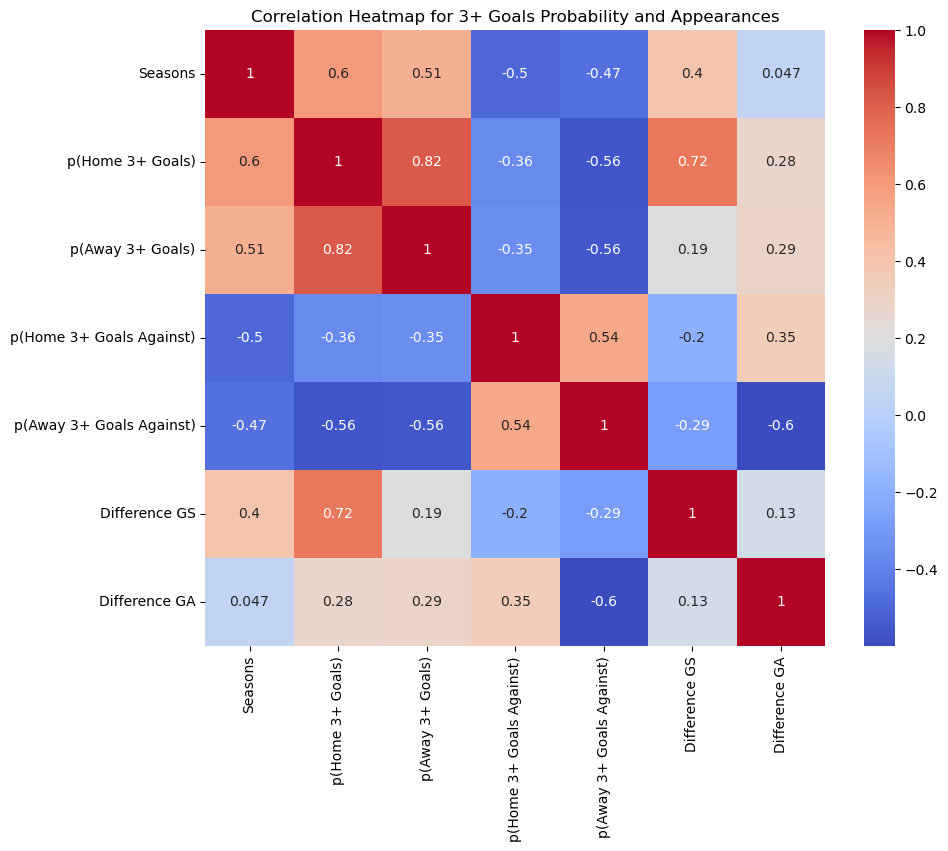

In [144]:
# correlation heatmap of the three_goals df with only the Appearance, p(Home 3+ Goals), p(Away 3+ Goals), and Difference columns
plt.figure(figsize=(10, 8))
sns.heatmap(three_goals[['Seasons', 'p(Home 3+ Goals)', 'p(Away 3+ Goals)', 'p(Home 3+ Goals Against)', 'p(Away 3+ Goals Against)', 'Difference GS', 'Difference GA']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for 3+ Goals Probability and Appearances')
plt.show()

There are a lot of strong correlations here:
- The strongest of which is p(home 3+) and p(away 3+) at 0.82. High scoring teams at home tend to also score a lot away, just on less occasions in absolute terms.
- Likewise, 0.54 corr between p(Home 3+ GA) and p(Away 3+ GA). Teams that concede a lot at home tend to also concede a lot away.
- Correlations with seasons:
    - As you might expect, fairly strong correlations between Seasons spent in the Prem and the tendency of scoring 3+ goals at home (0.6) and away (0.51)
    - In the same vein, fairly strong negative correlations between Seasons spent in the Prem and the tendency to concede 3+ goals at home (0.5) and away (0.47)
- Scoring 3 at home in a game is less negatively correlated to conceding 3 at home than conceding three away.    
    - This tells me the teams more regularly scoring 3 at home could also concede 3 at home more regularly than conceding three away.
- Ignoring the 0.6 Difference GA / p(Away 3+ GA as it's collinear)

Remember, unlike some of the other results based exploration, these are not symmetrical metrics. The individual teams outputs / performances in home and away games are recorded separately and conceptually different.

#### Who built a fortress?
- Teams with the largest home / away 3+ goals differential
- Teams having noticeably better performance at home or away
- If you score 3 goals in a game, you will almost always win
- If you concede 3 goals in a game, you will almost always lose

In [145]:
# order the teams by the difference column
three_goals_gs = three_goals[['Seasons', 'Home 3+ Goals', 'Away 3+ Goals', 'p(Home 3+ Goals)', 'p(Away 3+ Goals)', 'Difference GS']].sort_values(by='Difference GS', ascending=False)
three_goals_gs

,Seasons,Home 3+ Goals,Away 3+ Goals,p(Home 3+ Goals),p(Away 3+ Goals),Difference GS
Manchester City,8,69,34,0.454,0.224,0.230
Manchester United,8,60,35,0.395,0.230,0.165
Southampton,4,18,8,0.237,0.105,0.132
Swansea City,5,19,7,0.200,0.074,0.126
Portsmouth,2,5,1,0.132,0.026,0.106
Reading,1,3,1,0.158,0.053,0.105
Cardiff City,1,3,1,0.158,0.053,0.105
Stoke City,8,20,5,0.132,0.033,0.099
Newcastle United,7,23,10,0.173,0.075,0.098
Fulham,6,19,8,0.167,0.070,0.097


In [178]:
# teams most likely to score 3+ goals at home
three_goals_gs.sort_values(by='p(Home 3+ Goals)', ascending=False).head(10)

,Seasons,Home 3+ Goals,Away 3+ Goals,p(Home 3+ Goals),p(Away 3+ Goals),Difference GS
Manchester City,8,69,34,0.454,0.224,0.230
Manchester United,8,60,35,0.395,0.230,0.165
Arsenal,8,50,39,0.329,0.257,0.072
Liverpool,8,48,38,0.316,0.250,0.066
Chelsea,8,46,38,0.303,0.250,0.053
Southampton,4,18,8,0.237,0.105,0.132
Tottenham Hotspur,8,35,23,0.230,0.151,0.079
Everton,8,34,20,0.224,0.132,0.092
Leicester City,2,8,7,0.211,0.184,0.027
Swansea City,5,19,7,0.200,0.074,0.126


In [179]:
# teams most likely to score three away from home
three_goals_gs.sort_values(by='p(Away 3+ Goals)', ascending=False).head(10)

,Seasons,Home 3+ Goals,Away 3+ Goals,p(Home 3+ Goals),p(Away 3+ Goals),Difference GS
Arsenal,8,50,39,0.329,0.257,0.072
Chelsea,8,46,38,0.303,0.250,0.053
Liverpool,8,48,38,0.316,0.250,0.066
Manchester United,8,60,35,0.395,0.230,0.165
Manchester City,8,69,34,0.454,0.224,0.230
Leicester City,2,8,7,0.211,0.184,0.027
Crystal Palace,3,6,9,0.105,0.158,-0.053
Tottenham Hotspur,8,35,23,0.230,0.151,0.079
Bolton Wanderers,4,13,11,0.171,0.145,0.026
Everton,8,34,20,0.224,0.132,0.092


Some insights:
- **Generally, all of the Big Six dominate the home and away 3+ goals leaderboards above** but some of them are noticeably better at home: 
    - The Manchester clubs are monstrous at home! They score 3+ goals at home significantly more than their nearest chasers Liverpool, Arsenal and Chelsea.
    - They are the highest differentials, City by a huge margin and United considerably ahead of third place, Southampton.
    - By Contrast, most of the other Big Six (Arsenal, Liverpool, Chelsea and Tottenham) slightly exceed the Manchester clubs' Away 3+ goals tallies, but not enough to fully compensate for the significantly higher prolific scoring at home in Manchester.

- There seems to be a bit of a ceiling of scoring 3+ goals away from home at 25% of the time.
- There are a few exceptions but generally the biggest differentials between home & away differentials were the mainstays in the premier league during this time (being there for all 8 seasons). 

However, with some specific domain knowledge, we should look at **trajectory** of the clubs over time too.
- With the departure of legendary manager Sir Alex Ferguson in May 2013, Manchester United entered a period of relative mediocrity and I would anticipate these prolific goalscoring tendencies to begin declining
- Manchester City were bought out by an Emirati billionaire in 2008 and since then have had significant investment putting them into an upward trajectory.

#### LEICESTER CITY:
- It's worth mentioning that one anomaly here is Leicester City. Leicester City won the title at the end of 2015-16 season, the last in the dataset. In the 2014-15 season, they narrowly avoided relegation. 
- They therefore have two seasons in this dataframe which are statistical Jekyll-and-Hyde, and thus we may want to have a feature that gives us points per game for the particular season, which would capture season-specific dynamics a particular team is going through.

They are a good exercise in seeing the same team having two very different seasons:

In [177]:
# find all games where Leicester City are the home team or the away team
leicester = prem[(prem['home_team'] == 'Leicester City') | (prem['away_team'] == 'Leicester City')]

# find the number of times Leicester City have scored 3+ goals in the 14/15 Season - backslash is for line continuation
leicester_3_gs_14_15 = leicester[(leicester['season'] == '14/15') & (leicester['Home GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '14/15') & (leicester['Away GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0]

# number of times Leicester City conceded 3+ goals in the 14/15 season
leicester_3_ga_14_15 = leicester[(leicester['season'] == '14/15') & (leicester['Home GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '14/15') & (leicester['Away GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0]

print(f'Leicester City scored 3+ goals in {leicester_3_gs_14_15} games and conceded 3+ goals in {leicester_3_ga_14_15} games in the 14/15 season.')

# find the number of times Leicester City have scored 3+ goals in the 15/16 Season
leicester_3_gs_15_16 = leicester[(leicester['season'] == '15/16') & (leicester['Home GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '15/16') & (leicester['Away GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0]

# find the number of times Leicester City conceded 3+ goals in the 15/16 season
leicester_3_ga_15_16 = leicester[(leicester['season'] == '15/16') & (leicester['Home GS'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '15/16') & (leicester['Away GS'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0]

print(f'Leicester City scored 3+ goals in {leicester_3_gs_15_16} games and conceded 3+ goals in {leicester_3_ga_15_16} games in the 15/16 season.')

Leicester City scored 3+ goals in 5 games and conceded 3+ goals in 6 games in the 14/15 season.
Leicester City scored 3+ goals in 10 games and conceded 3+ goals in 1 games in the 15/16 season.


Above: 14/15 was a survival season and 15/16 was a title-winning season

#### Who gets humbled?

In [147]:
# order the teams by the difference column
three_goals_ga = three_goals[['Seasons', 'Home 3+ Goals Against', 'Away 3+ Goals Against', 'p(Home 3+ Goals Against)', 'p(Away 3+ Goals Against)', 'Difference GA']].sort_values(by='p(Away 3+ Goals Against)', ascending=False)
three_goals_ga

,Seasons,Home 3+ Goals Against,Away 3+ Goals Against,p(Home 3+ Goals Against),p(Away 3+ Goals Against),Difference GA
Blackpool,1,7,8,0.368,0.421,-0.053
Blackburn Rovers,4,6,29,0.079,0.382,-0.303
Burnley,2,7,14,0.184,0.368,-0.184
Cardiff City,1,5,7,0.263,0.368,-0.105
Reading,1,5,7,0.263,0.368,-0.105
Queens Park Rangers,3,7,20,0.123,0.351,-0.228
Norwich City,4,11,24,0.145,0.316,-0.171
Newcastle United,7,23,38,0.173,0.286,-0.113
Wolverhampton Wanderers,3,14,16,0.246,0.281,-0.035
Bournemouth,1,6,5,0.316,0.263,0.053


As you might expect the teams spending the least seasons in the PL have the higher probabilities of shipping 3+ goals. Is it more pronounced shipping home or away goals? 

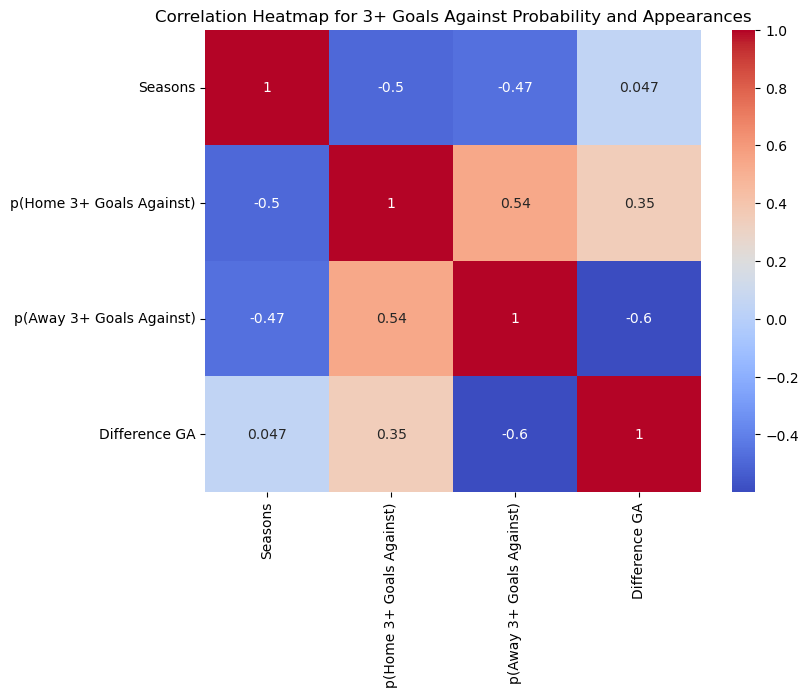

In [181]:
# correlation heatmap of three_goals_ga with seasons, p(Home 3+ Goals Against), p(Away 3+ Goals Against), and Difference GA
plt.figure(figsize=(8, 6))
sns.heatmap(three_goals_ga[['Seasons', 'p(Home 3+ Goals Against)', 'p(Away 3+ Goals Against)', 'Difference GA']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for 3+ Goals Against Probability and Appearances')
plt.show()


'Staying in the Premier League' is almost equally negatively correlated with the tendency to ship 3 at home or away, very slightly favouring this at home which makes sense - many small teams looking to survive build their survival on at least being hard to beat at home where they target the most wins.

### Points Per Game (ppg)
- Give an overall (across the 8 seasons) points per game tally based on 3 for a win, 1 for a draw and 0 for a loss
- Stretch: should we add home_ppg and away_ppg?
- These will go into the prem df

In [ ]:
# variable created above: appaearances
appearances.sample(5)

West Bromwich Albion    266
Bournemouth              38
Crystal Palace          114
Reading                  38
Middlesbrough            38
Name: count, dtype: int64

In [155]:
# number of wins, draws, and losses for each team
home_wins = prem[prem['Result'] == 1]['home_team'].value_counts()
away_wins = prem[prem['Result'] == -1]['away_team'].value_counts()
draws = prem[prem['Result'] == 0]['home_team'].value_counts().add(prem[prem['Result'] == 0]['away_team'].value_counts(), fill_value=0)
home_losses = prem[prem['Result'] == -1]['home_team'].value_counts()
away_losses = prem[prem['Result'] == 1]['away_team'].value_counts()

points = (home_wins * 3).add(away_wins * 3, fill_value=0).add(draws, fill_value=0)

# now create a dataframe with all the above data and appearances
pl_points = pd.DataFrame({
    'Appearances': appearances,
    'Home Wins': home_wins,
    'Away Wins': away_wins,
    'Draws': draws,
    'Home Losses': home_losses,
    'Away Losses': away_losses,
    'Points': points
})

pl_points.head()

,Appearances,Home Wins,Away Wins,Draws,Home Losses,Away Losses,Points
Arsenal,304,97,73,73,21,40,583
Aston Villa,304,45,41,88,57,73,346
Birmingham City,76,14,7,26,7,22,89
Blackburn Rovers,152,29,13,39,26,45,165
Blackpool,38,5,5,9,9,10,39


In [156]:
# points per game column
pl_points['Points per Game'] = round(pl_points['Points'] / (pl_points['Appearances']), 2)

In [157]:
pl_points

,Appearances,Home Wins,Away Wins,Draws,Home Losses,Away Losses,Points,Points per Game
Arsenal,304,97,73,73,21,40,583,1.92
Aston Villa,304,45,41,88,57,73,346,1.14
Birmingham City,76,14,7,26,7,22,89,1.17
Blackburn Rovers,152,29,13,39,26,45,165,1.09
Blackpool,38,5,5,9,9,10,39,1.03
Bolton Wanderers,152,27,16,33,29,47,162,1.07
Bournemouth,38,5,6,9,9,9,42,1.11
Burnley,76,11,4,18,15,28,63,0.83
Cardiff City,38,5,2,9,9,13,30,0.79
Chelsea,304,101,75,70,17,41,598,1.97


Now we have an another easy way to see performance other than net_goals per game (which was influential in the first run, but this may be even more so)

In [152]:
prem.sample(5)

,id,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
345,2074,08/09,2008-09-27,6,Newcastle United,1,2,Blackburn Rovers,-1,-1,...,23170,30646,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>47</comment><event...
1832,3561,12/13,2013-05-19,38,Manchester City,2,3,Norwich City,-1,-1,...,35493,24698,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>30</comment><event...
2913,4642,15/16,2016-04-03,32,Leicester City,1,0,Southampton,1,1,...,538112,41280,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>82</comment><stats...
27,1756,08/09,2008-11-01,11,Portsmouth,1,2,Wigan Athletic,-1,-1,...,34466,127857,<goal><value><comment>p</comment><stats><penal...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...
2640,4369,14/15,2014-10-18,8,Arsenal,2,2,Hull City,0,0,...,26163,105548,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>73</comment><event...


### This team's form this season (points per game, last 5 results)
The EDA around Leicester City having two completely different seasons in terms of performance shows that a lot of model performance will be in capturing the current season dynamics of the team. This can mean:
- Points per game so far this season, (for this season where gameweek is less than the current record, find the win/draw/losses of the team)
- Last 5 league results (how to encode this? Let's first try the sum of points in the last 5 games
- Try it first with Leicteser City in a small df

In [203]:
# drop all columns in leicester df except season, date, gameweek / 38, home team, home gs, away gs, away team, result, margin 
leicester = leicester[['season', 'date', 'Gameweek / 38', 'home_team', 'Home GS', 'Away GS', 'away_team', 'Result', 'Margin']]
leicester.sort_values(by='Gameweek / 38').head(10)


,season,date,Gameweek / 38,home_team,Home GS,Away GS,away_team,Result,Margin
2282,14/15,2014-08-16,1,Leicester City,2,2,Everton,0,0
2664,15/16,2015-08-08,1,Leicester City,4,2,Sunderland,1,2
2779,15/16,2015-08-15,2,West Ham United,1,2,Leicester City,-1,-1
2391,14/15,2014-08-23,2,Chelsea,2,0,Leicester City,1,2
2883,15/16,2015-08-22,3,Leicester City,1,1,Tottenham Hotspur,0,0
2503,14/15,2014-08-31,3,Leicester City,1,1,Arsenal,0,0
2981,15/16,2015-08-29,4,Bournemouth,1,1,Leicester City,0,0
2607,14/15,2014-09-13,4,Stoke City,0,1,Leicester City,-1,-1
2993,15/16,2015-09-13,5,Leicester City,3,2,Aston Villa,1,1
2613,14/15,2014-09-21,5,Leicester City,5,3,Manchester United,1,2


Calculating Points per game and last 5 below:

In [208]:
def calculate_team_metrics(df):
    """
    Add 'ppg_season' and 'last_5_games' columns to the dataframe.

    Parameters:
        df (pd.DataFrame): DataFrame containing match data with 'season', 'Gameweek / 38',
                           'home_team', 'away_team', 'Home GS', and 'Away GS'.

    Returns:
        pd.DataFrame: Updated DataFrame with 'ppg_season' and 'last_5_games' columns.
    """
    # Initialize new columns
    df['ppg_season'] = 0.0
    df['last_5_games'] = 0

    # Iterate over each unique season
    for season in df['season'].unique():
        season_df = df[df['season'] == season]
        print(f'Calculating metrics for {season}...')

        # Iterate over each unique team name in the season
        for team_name in pd.concat([season_df['home_team'], season_df['away_team']]).unique():
            print(f'Calculating metrics for {team_name}...')
            # Initialize a list to track game points for the team
            team_points = []

            # Iterate over records sorted by gameweek
            for _, row in season_df.sort_values(by='Gameweek / 38').iterrows(): 
                print(f'Calculating metrics for gameweek {row["Gameweek / 38"]}...')
                is_home_team = row['home_team'] == team_name
                is_away_team = row['away_team'] == team_name

                if not (is_home_team or is_away_team):
                    continue

                # Determine points for the current game
                if is_home_team:
                    if row['Home GS'] > row['Away GS']:
                        points = 3  # Home win
                    elif row['Home GS'] == row['Away GS']:
                        points = 1  # Draw
                    else:
                        points = 0  # Loss
                else:  # Away team
                    if row['Away GS'] > row['Home GS']:
                        points = 3  # Away win
                    elif row['Away GS'] == row['Home GS']:
                        points = 1  # Draw
                    else:
                        points = 0  # Loss
                print(f'{team_name} earned {points} point(s) in gameweek {row["Gameweek / 38"]}')

                # Calculate 'ppg_season'
                if row["Gameweek / 38"] > 1:
                    df.loc[row.name, 'ppg_season'] = sum(team_points) / len(team_points)
                else:
                    df.loc[row.name, 'ppg_season'] = 0.0  # First gameweek, no games yet
                print(f'{team_name} has averaged {df.loc[row.name, "ppg_season"]} points per game so far this season')

                # Calculate 'last_5_games' (sum of points in the last 5 games, excluding current game)
                df.loc[row.name, 'last_5_games'] = sum(team_points[-5:])
                print(f'{team_name} has earned {df.loc[row.name, "last_5_games"]} points in the last 5 games')
                print("\n")

                # Append the current game's points to the list
                team_points.append(points)

    return df


In [209]:
calculate_team_metrics(leicester)

Calculating metrics for 14/15...
Calculating metrics for Leicester City...
Calculating metrics for gameweek 1...
Leicester City earned 1 point(s) in gameweek 1
Leicester City has averaged 0.0 points per game so far this season
Leicester City has earned 0 points in the last 5 games


Calculating metrics for gameweek 2...
Leicester City earned 0 point(s) in gameweek 2
Leicester City has averaged 1.0 points per game so far this season
Leicester City has earned 1 points in the last 5 games


Calculating metrics for gameweek 3...
Leicester City earned 1 point(s) in gameweek 3
Leicester City has averaged 0.5 points per game so far this season
Leicester City has earned 1 points in the last 5 games


Calculating metrics for gameweek 4...
Leicester City earned 3 point(s) in gameweek 4
Leicester City has averaged 0.6666666666666666 points per game so far this season
Leicester City has earned 2 points in the last 5 games


Calculating metrics for gameweek 5...
Leicester City earned 3 point(s) in 

ZeroDivisionError: division by zero

In [195]:
leicester['last_5_games'].value_counts()

last_5_games
0    52
3    14
1    10
Name: count, dtype: int64

### When Big Teams collide
- Against mediocre teams, Big Teams are likely more able to turn draws into away wins, and steer promising home teams into draws when playing away
- Are they able to force results (not play out draws) against each other as easily?

### Let's explore the HTML of the match stats columns

In [676]:
prem['goal'].iloc[0]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>'

In [677]:
# check the record with id column 4766 in the goal column - a 0-0 draw
prem[prem['id'] == 4766]['goal']

4765    <goal />
Name: goal, dtype: object

In [678]:
# check where it's a 1-0 win just one entry - the last entry in the data
prem['goal'].iloc[-1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>649</event_incident_typefk><coordinates><value>21</value><value>2</value></coordinates><elapsed>54</elapsed><subtype>tap_in</subtype><player1>239807</player1><sortorder>4</sortorder><team>8659</team><id>4910256</id><n>559</n><type>goal</type><goal_type>n</goal_type></value></goal>'

It's very hard to read without seeing the nesting. We can use BeautifulSoup to parse this and see what is actually in here, is it anything more detailed than what we see in the goals scored column already?

In [679]:
from bs4 import BeautifulSoup

# prettify the HTML content from a dataframe
def prettify_column(col):
    soup = BeautifulSoup(col, 'html.parser')
    return soup.prettify()

# Applying the function to the goal column
prem['goal_parsed'] = prem['goal'].apply(prettify_column)

# Now, you can print an example entry to see the formatted HTML
print(prem['goal_parsed'].iloc[0])


<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   406
  </event_incident_typefk>
  <elapsed>
   22
  </elapsed>
  <player2>
   38807
  </player2>
  <subtype>
   header
  </subtype>
  <player1>
   37799
  </player1>
  <sortorder>
   5
  </sortorder>
  <team>
   10261
  </team>
  <id>
   378998
  </id>
  <n>
   295
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <elapsed>
   24
  </elapsed>
  <player2>
   24154
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   24148
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   10260
  </team>
  <id>
   379019
  </id>
  <n>
   298
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



In [680]:
print(prem['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   649
  </event_incident_typefk>
  <coordinates>
   <value>
    21
   </value>
   <value>
    2
   </value>
  </coordinates>
  <elapsed>
   54
  </elapsed>
  <subtype>
   tap_in
  </subtype>
  <player1>
   239807
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   8659
  </team>
  <id>
   4910256
  </id>
  <n>
   559
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



### goal column contains:
- a < goal /> tag if there are no goals

- a value tag for every goal
    - within this value tag, there is a comment tag which has mostly 'n' but also other letters. I don't know the meaning of it yet
    - elapsed, which may be the minute of the game it was scored,
    - **goal subtype** including header, tap-in, good data here!
    - **coordinates** which must be X and Y, e.g. the tap-in has coordinates value 21, 2 (2 yards out from the goal?)
    - team id
    - id which I assume is a goal_id?

I want to extract:
- goal subtype and see what types they have recorded
- comment, to see if it can be entirely ignored if it's just 'n'
- later on, we will get elapsed, assuming this is time the goal was scored

In [681]:
# Function to extract <comment> and <subtype> values, with a check for <value> tags
def extract_comment_and_subtype(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Check if there is a <goal> tag and if it contains <value> tags
    goal_tag = soup.find('goal')
    if not goal_tag or not goal_tag.find_all('value'):
        return [], []  # Return empty lists if <goal> or <value> is not found
    
    # Extract all <comment> and <subtype> values within each <value> tag
    comments = [value_tag.find('comment').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('comment')]
    subtypes = [value_tag.find('subtype').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('subtype')]
    
    return comments, subtypes

# Apply the function to extract <comment> and <subtype> values from the 'goal' column
prem['goal_comments'], prem['goal_subtypes'] = zip(*prem['goal'].apply(extract_comment_and_subtype))

# Flatten the lists and get unique values
unique_comments = set([comment for sublist in prem['goal_comments'] for comment in sublist])
unique_subtypes = set([subtype for sublist in prem['goal_subtypes'] for subtype in sublist])

# Print the unique comments and subtypes
print("Unique Comments:", unique_comments)
print("Unique Subtypes:", unique_subtypes)


Unique Comments: {'o', 'npm', 'rp', 'n', 'psm', 'dg', 'p'}
Unique Subtypes: {'lob', 'saved_back_into_play', 'indirect freekick', 'missed', 'bicycle_kick', 'shot', 'deflected', 'crossbar', 'volley', 'distance', 'backheel', 'header', 'tap_in', 'direct_freekick', 'loose_ball', 'saved', 'post'}


We can see a lot of different subtypes including 'saved' or 'missed' which doesn't make sense. Let's see which fields have those

In [682]:
# check goal_subtypes for entries containing 'missed' and 'saved'
missed = prem[prem['goal_subtypes'].apply(lambda x: 'missed' in x or 'saved' in x)]

missed

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
1769,1770,08/09,13,2008-11-15,489163,9825,10252,0,2,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, o, n]","[saved, shot]"
1886,1887,08/09,23,2009-01-28,489271,8655,8559,2,2,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, npm, n]","[shot, shot, shot, saved, shot]"
1951,1952,08/09,3,2008-08-30,489065,8654,8655,4,1,1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>68</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, o, n, dg, npm, n, n]","[header, shot, shot, saved, shot, shot]"
1953,1954,08/09,3,2008-08-30,489067,8668,8462,0,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, npm, n]","[shot, shot, saved, distance]"
1960,1961,08/09,30,2009-03-21,489335,10261,9825,1,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, n, n, n, n]","[saved, header, loose_ball, shot, shot]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,4481,15/16,18,2015-12-26,1988882,8455,9817,2,2,0,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p, o, n, npm]","[volley, shot, missed]"
4482,4483,15/16,18,2015-12-26,1988884,8456,8472,4,1,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>72</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, npm]","[header, distance, header, shot, shot, missed]"
4616,4617,15/16,3,2015-08-23,1988738,8659,8455,2,3,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value>

I was manually trying to compare the sum of Home GS + Away GS with the number of goal subtypes and there are some inconsistencies where saved and missed are involved. We can:

- spot check some records with those and see if goal has a value of 1 or 0
- run a pandas query for these where the sum of goals should add up to the length of the goal_subtypes list

In [683]:
print(missed['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <coordinates>
   <value>
    23
   </value>
   <value>
    6
   </value>
  </coordinates>
  <elapsed>
   5
  </elapsed>
  <player2>
   103419
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   286119
  </player1>
  <sortorder>
   6
  </sortorder>
  <team>
   8197
  </team>
  <id>
   5581005
  </id>
  <n>
   301
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   80
  </event_incident_typefk>
  <coordinates>
   <value>
    25
   </value>
   <value>
    7
   </value>
  </coordinates>
  <elapsed>
   33
  </elapsed>
  <subtype>
   shot
  </subtype>
  <player1>
   103419
  </player1>
  <sortorder>
   2
  </sortorder>
  <tea

## Pause on Pandas: Bring in key information using SQL to aid the analysis

SQL is going to be a lot easier to bring in information like how many goals on average did a given team score this season, team OVR rating for the season, player OVR ratings etc...

Before going for types of goals, possession etc etc I should be looking at high level team information, which is definitely going to impact the predictive power of the model.

The SQL query to be built is:
- Overall Rating From Player_Attributes, join their name
    - we need code to match the player's OVR ability to the year the match takes place e.g. 2015 match takes the player's 2015 OVR
- Joined by their player_api_id to Match table, which has player ID

In [684]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    # countries = pd.read_sql_query("SELECT England FROM Country", conn) # we don't need it for now, other than country id 1729

    matches = pd.read_sql_query("SELECT * FROM Match WHERE country_id IS 1729", conn)

    # leagues = pd.read_sql_query("SELECT * FROM League", conn) - we don't need this right now

    team = pd.read_sql_query("SELECT * FROM Team", conn)

    team_attr = pd.read_sql_query("""
                                  SELECT Team.team_api_id, team_long_name, date, buildUpPlaySpeed, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression
                                  FROM Team_Attributes
                                  INNER JOIN Team ON Team.team_api_id = Team_Attributes.team_api_id
                                  """, conn)

    player_attr = pd.read_sql_query("""
                                    SELECT Player.player_api_id, player_name, date, overall_rating 
                                    FROM Player_Attributes 
                                    INNER JOIN Player ON Player.player_api_id = Player_Attributes.player_api_id
                                    """, conn)

    player = pd.read_sql_query("SELECT * FROM Player", conn)

### Preparing the player_attribute table

The goal is to have the player id, their overall rating and the year in which it was assigned. This information will let the player easily be joined in to the matches table with their overall rating which is close to the time of the match in question.
    - We can then later create an average OVR rating of the team in the starting 11.

There are many instances of the same player having a new rating multiple times a year, so we will take an average of the overall rating that was given in each rating across each year.

In [685]:
player_attr[player_attr['player_api_id'] == 23021].head() # before preparation

,player_api_id,player_name,date,overall_rating
21897,23021,Boaz Myhill,2016-02-11 00:00:00,72.0
21898,23021,Boaz Myhill,2015-09-21 00:00:00,72.0
21899,23021,Boaz Myhill,2014-05-16 00:00:00,72.0
21900,23021,Boaz Myhill,2014-03-14 00:00:00,72.0
21901,23021,Boaz Myhill,2013-09-20 00:00:00,72.0


In [686]:
# cast date to datetime
player_attr['date'] = pd.to_datetime(player_attr['date'])

# extract just the year from the date
player_attr['date'] = player_attr['date'].dt.year

In [687]:
# now average the overall_rating for each player for each year, group by player_api_id and date
player_attr = player_attr.groupby(['player_api_id', 'player_name', 'date'])['overall_rating'].mean().reset_index()

# round the overall_rating to 1 decimal place
player_attr['overall_rating'] = player_attr['overall_rating'].round(1)

In [688]:
player_attr.dtypes

player_api_id       int64
player_name        object
date                int32
overall_rating    float64
dtype: object

In [689]:
player_attr.sample(5) # after preparation

,player_api_id,player_name,date,overall_rating
19165,34225,Tomasz Kupisz,2012,68.5
67382,355356,Marc-Oliver Kempf,2007,57.0
15679,31643,David Elm,2013,62.0
11057,27352,Jan Rosenthal,2010,73.0
17774,33579,Oscar Wendt,2015,76.0


### Preparing the team_attribute columns

The goal is to have the team statistics for that year that the match took place. We may only bring in the team name but extra columns related to the style of play will be brought in too. 

I dropped buildUpPlayDribbling / chanceCreationDribbling because it only began getting recorded in 2014 - near the end of the data

Other notes:
- It looks like all teams get one annual rating for team_attr, so all we need to process is extract the year

- Spot check West Ham (long ball) vs Arsenal (short possession based) - it appears the **larger values for passing indicate longer passing distance**, e.g. long-ball teams have a larger buildUpPlaySpeed and buildUpPlayPassing

In [690]:
#teams[teams['team_api_id'] == 8654]

In [691]:
team_attr.sample(5) # before processing

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
659,8203,KV Mechelen,2010-02-22 00:00:00,65,60,50,40,50,60,70
1161,8302,Sevilla FC,2015-09-10 00:00:00,53,53,53,52,60,42,48
675,8543,Lazio,2010-02-22 00:00:00,60,50,50,40,70,55,50
445,10243,FC Zürich,2010-02-22 00:00:00,45,60,45,70,50,50,55
767,8689,FC Lorient,2013-09-20 00:00:00,60,42,48,53,64,43,47


In [692]:
team_attr.columns

Index(['team_api_id', 'team_long_name', 'date', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression'],
      dtype='object')

In [693]:
# spot check a team to see how this changes - West Ham United and Arsenal
team_attr[team_attr['team_long_name'].isin(['West Ham United', 'Arsenal'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
70,9825,Arsenal,2010-02-22 00:00:00,66,30,30,45,35,30,40
71,9825,Arsenal,2011-02-22 00:00:00,75,40,40,45,65,50,40
72,9825,Arsenal,2012-02-22 00:00:00,25,32,41,34,30,57,57
73,9825,Arsenal,2013-09-20 00:00:00,30,29,41,55,39,64,54
74,9825,Arsenal,2014-09-19 00:00:00,59,26,28,55,64,51,44
75,9825,Arsenal,2015-09-10 00:00:00,59,30,28,44,46,51,44
1384,8654,West Ham United,2010-02-22 00:00:00,58,30,31,70,50,30,70
1385,8654,West Ham United,2011-02-22 00:00:00,35,35,30,45,45,45,45
1386,8654,West Ham United,2012-02-22 00:00:00,63,64,44,60,55,30,34
1387,8654,West Ham United,2013-09-20 00:00:00,72,73,61,74,32,30,37


In [694]:
# cast date to datetime
team_attr['date'] = pd.to_datetime(team_attr['date'])

# extract just the year from the date
team_attr['date'] = team_attr['date'].dt.year

In [695]:
team_attr.sample(5)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
154,10211,SC Beira Mar,2013,39,48,53,53,59,37,52
798,8661,RCD Mallorca,2014,62,57,53,57,53,59,41
222,4170,US Boulogne Cote D'Opale,2011,50,35,35,65,65,35,55
486,9987,KRC Genk,2012,53,55,55,48,56,47,45
1022,8696,Racing Santander,2013,47,44,61,71,50,50,50


### Big SQL Query - team match results in England

I want to create a df which has aggregated the win/loss/draw and avg goals scored for all teams in England (where the matches recorded are all from the Premier League).

We will use CASE logic to match the team id only when it is specifically home or away to count the goals scored and the goals per match
We can make it more granular later e.g. home wins/losses, away wins/losses if we want.

We can also adjust the below code to add other leagues for if we wanted to check which teams are most dominant in their leagues.

In [696]:
sql_query = """
SELECT
    Team.team_api_id,
    Team.team_long_name AS name,
    League.name AS league,
    COUNT(Match.id) AS total_matches,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END) AS total_GS,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END) AS total_GA,
    SUM(CASE 
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                ELSE 0 
        END) AS total_wins,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal = Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal = Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_draws,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_losses,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END), 2) AS avg_GS_per_match,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END), 2) AS avg_GA_per_match

FROM Team

LEFT JOIN Match ON Team.team_api_id IN (Match.home_team_api_id, Match.away_team_api_id)

JOIN League ON League.id = Match.league_id

WHERE Team.team_api_id IS NOT NULL AND League.id = 1729

GROUP BY Team.team_long_name

ORDER BY total_wins DESC;
"""

In [697]:
# SQL query run

big_stats = pd.read_sql_query(sql_query, conn)

In [698]:
big_stats

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
0,10260,Manchester United,England Premier League,304,582,280,192,57,55,1.91,0.92
1,8455,Chelsea,England Premier League,304,583,286,176,70,58,1.92,0.94
2,8456,Manchester City,England Premier League,304,606,307,175,61,68,1.99,1.01
3,9825,Arsenal,England Premier League,304,573,320,170,73,61,1.88,1.05
4,8586,Tottenham Hotspur,England Premier League,304,481,358,151,74,79,1.58,1.18
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11
6,8668,Everton,England Premier League,304,439,355,121,100,83,1.44,1.17
7,10194,Stoke City,England Premier League,304,322,401,98,86,120,1.06,1.32
8,10252,Aston Villa,England Premier League,304,335,462,86,88,130,1.10,1.52
9,10261,Newcastle United,England Premier League,266,324,422,82,65,119,1.22,1.59


In [699]:
big_stats.dtypes # types look good

team_api_id           int64
name                 object
league               object
total_matches         int64
total_GS              int64
total_GA              int64
total_wins            int64
total_draws           int64
total_losses          int64
avg_GS_per_match    float64
avg_GA_per_match    float64
dtype: object

In [700]:
# close the SQL connection
conn.close()

## Progress Check - SQL and Pandas

We have:

- `player_attr` player overall attribute for every year, which can be summed and averaged in the match data table, with player_api to connect to the team
- `team_attr` team statistics, with team_api_id and the date. If we have issues with nulls, we may want to start with just the 2010 - 2015 or 2016 years as some team attribute data is missing from 2008-2009
- `big_stats` aggregated team results for the 33 teams who have competed in the premier league in this 2008-2016 window
- `prem` which is a modified match table where all of this will be aggregated.

In [701]:
# spot check the team_attr for teams that could be pulled in
team_attr[team_attr['team_long_name'].isin(['Middlesbrough', 'Fulham'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
478,9879,Fulham,2010,60,70,70,70,50,40,35
479,9879,Fulham,2011,50,55,45,55,40,45,35
480,9879,Fulham,2012,48,45,38,62,54,38,38
481,9879,Fulham,2013,52,49,49,56,59,39,39
482,9879,Fulham,2014,52,56,58,41,54,29,28
483,9879,Fulham,2015,52,48,39,54,59,29,30
829,8549,Middlesbrough,2010,70,70,70,70,50,30,70
830,8549,Middlesbrough,2011,66,51,64,64,48,54,44
831,8549,Middlesbrough,2012,60,72,40,56,72,38,42
832,8549,Middlesbrough,2013,60,40,40,56,57,38,42


### Sample Pulse Check for the four dfs

In [702]:
prem.sample(7)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
2361,2362,09/10,32,2010-03-27,659132,8559,10260,0,4,-1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,<goal>\n <value>\n <comment>\n o\n </comme...,"[o, n, n, n]","[shot, shot, shot]"
4173,4174,14/15,24,2015-02-08,1724217,10261,10194,1,1,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>60</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[shot, header]"
3490,3491,12/13,31,2013-03-30,1229432,8668,10194,1,0,1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><event_incident_typefk>595</ev...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>54</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]
3473,3474,12/13,3,2012-09-01,1228306,10003,8472,2,2,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>60</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n]","[shot, shot, tap_in, header]"
2992,2993,11/12,20,2012-01-03,1025207,8456,8650,3,0,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>52</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, p]","[shot, header]"
4551,4552,15/16,24,2016-02-02,1988943,8472,8456,0,1,-1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>36</comment><stats...,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]
1900,1901,08/09,25,2009-02-08,489285,8654,10260,0,1,-1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>35</comment><event...,<goal>\n <value>\n <comment>\n dg\n </comm...,"[dg, n]","[shot, shot]"


In [703]:
player_attr.sample(7)

,player_api_id,player_name,date,overall_rating
39438,89240,Adam Hlousek,2009,59.5
42217,102879,Salva Sevilla,2007,59.0
44079,112117,Diallo Guidilleye,2011,65.5
36621,69085,Tomasz Foszmanczyk,2007,50.0
36377,68516,Ramon Cardozo,2015,72.0
37595,71903,Linus Hallenius,2012,64.0
72973,693171,Ludovic Blas,2016,59.0


In [704]:
team_attr.sample(7)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
20,8564,Milan,2015,48,52,66,36,69,58,57
616,8066,Inverness Caledonian Thistle,2014,61,59,50,57,55,43,41
595,8226,TSG 1899 Hoffenheim,2015,69,53,66,62,59,63,61
309,8455,Chelsea,2013,46,41,46,61,63,42,43
1355,10238,Vitória Setúbal,2012,56,42,54,52,52,37,37
1070,8690,Reggio Calabria,2014,52,56,57,74,53,38,48
791,9864,Málaga CF,2013,45,36,72,69,50,64,58


In [705]:
big_stats.sample(7)

,team_api_id,name,league,total_matches,total_GS,total_GA,total_wins,total_draws,total_losses,avg_GS_per_match,avg_GA_per_match
33,9798,Reading,England Premier League,38,43,73,6,10,22,1.13,1.92
19,9850,Norwich City,England Premier League,152,160,253,39,41,72,1.05,1.66
8,10252,Aston Villa,England Premier League,304,335,462,86,88,130,1.10,1.52
23,8602,Wolverhampton Wanderers,England Premier League,114,118,204,25,28,61,1.04,1.79
16,8528,Wigan Athletic,England Premier League,190,200,320,50,52,88,1.05,1.68
14,10003,Swansea City,England Premier League,190,233,257,62,52,76,1.23,1.35
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11


## Combining the dataframes

The goal is:
- In the Prem dataframe, we can replace the home_player_x and away_player_x which are currently just IDs with overall ability values using player_attr
- We can also add in an average OVR for both team's starting 11
    - later on, other team attributes we want to investigate
- We may want to add the team's avg GS and GA, but might this be a problem of collinearity with the classification result?
- We can then have a target column for classification of 1 (home win), 0 (draw) or -1 (away win)

In [706]:
prem.sample(5)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,shoton,shotoff,foulcommit,card,cross,corner,possession,goal_parsed,goal_comments,goal_subtypes
3576,3577,12/13,4,2012-09-15,1228351,10194,8456,1,1,0,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>48</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[shot, header]"
2760,2761,10/11,34,2011-04-23,840187,8472,8528,4,2,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, p, n, n]","[distance, header, shot, shot, shot]"
4523,4524,15/16,21,2016-01-13,1988915,8456,8668,0,0,0,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><stats...,<goal>\n</goal>\n,[],[]
3459,3460,12/13,29,2013-04-17,1229408,9879,8455,0,3,-1,...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n]","[distance, header, header]"
1939,1940,08/09,29,2009-03-14,489324,9825,8655,4,0,1,...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><event_incident_typefk>123</even...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>58</comment><event...,<goal>\n <value>\n <comment>\n o\n </comme...,"[o, n, n, p]","[shot, volley]"


In [707]:
prem.columns

Index(['id', 'season', 'Round / 38', 'date', 'match_api_id', 'Home ID',
       'Away ID', 'Home GS', 'Away GS', 'Result', 'Margin', 'p(Home)',
       'p(Draw)', 'p(Away)', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'goal_parsed', 'goal_comments', 'goal_subtypes'],
      dtype='object')

### Adding Player Ratings and Team statistics to prem df

In [708]:
# Convert the 'date' columns to datetime and extract the year
prem['date'] = pd.to_datetime(prem['date'])
prem['year'] = prem['date'].dt.year

player_attr['date'] = pd.to_datetime(player_attr['date'])
player_attr['year'] = player_attr['date'].dt.year

# Function to merge and find the nearest year if an exact match is not available
def merge_with_nearest_year(prem_df, player_attr_df, player_col, rating_col_prefix):
    # Sort player_attr by player_id and year
    player_attr_df = player_attr_df.sort_values(['player_api_id', 'year'])
    
    # Initialize a list to hold the rating data
    ratings = []

    # Iterate over each row in prem_df
    for _, row in prem_df.iterrows():
        player_id = row[player_col]
        match_year = row['year']

        # Filter player_attr for the current player_id
        player_data = player_attr_df[player_attr_df['player_api_id'] == player_id]

        # Find the closest year if there are any records for the player
        if not player_data.empty:
            closest_year = player_data.iloc[(player_data['year'] - match_year).abs().argsort()[:1]].squeeze()
            ratings.append(closest_year['overall_rating'])
        else:
            ratings.append(None)  # Append None if no data is available

    # Add the ratings to the prem_df
    prem_df[rating_col_prefix] = ratings

# Apply the function for home and away players
for n in range(1, 12):
    merge_with_nearest_year(prem, player_attr, f'home_player_{n}', f'home_player_{n}_rating')
    merge_with_nearest_year(prem, player_attr, f'away_player_{n}', f'away_player_{n}_rating')

# adding the team statistics to the prem df
prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Home ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'home_total_matches',
    'avg_GS_per_match': 'home_avg_GS_per_match',
    'avg_GA_per_match': 'home_avg_GA_per_match'
}).drop(columns='team_api_id')

prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GS_per_match', 'avg_GA_per_match']],
    left_on='Away ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'away_total_matches',
    'avg_GS_per_match': 'away_avg_GS_per_match',
    'avg_GA_per_match': 'away_avg_GA_per_match'
}).drop(columns='team_api_id')

In [709]:
prem.sample(10)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
1717,3446,12/13,27,2013-02-23,1229392,9798,8528,0,3,-1,...,72.5,77.0,68.0,71.0,38,1.13,1.92,190,1.05,1.68
41,1770,08/09,13,2008-11-15,489163,9825,10252,0,2,-1,...,73.5,76.5,73.0,74.0,304,1.88,1.05,304,1.10,1.52
303,2032,08/09,37,2009-05-16,489406,8549,10252,1,1,0,...,78.5,78.0,66.0,75.0,38,0.74,1.50,304,1.10,1.52
110,1839,08/09,2,2008-08-23,489052,8650,8549,2,1,1,...,85.0,79.0,87.0,78.5,304,1.75,1.11,38,0.74,1.50
1750,3479,12/13,30,2013-03-16,1229418,10252,10172,3,2,1,...,56.0,75.0,74.0,62.0,304,1.10,1.52,114,1.01,1.75
2720,4449,15/16,15,2015-12-05,1988850,9825,8472,3,1,1,...,52.0,70.0,56.0,68.5,304,1.88,1.05,304,1.10,1.45
301,2030,08/09,37,2009-05-16,489404,8586,8456,2,1,1,...,65.0,80.5,83.5,61.0,304,1.58,1.18,304,1.99,1.01
1439,3168,11/12,36,2012-04-28,1026093,8528,10261,4,0,1,...,71.0,67.0,76.5,65.0,190,1.05,1.68,266,1.22,1.59
1575,3304,12/13,14,2012-11-28,1229244,10003,8659,3,1,1,...,72.0,79.5,64.0,74.0,190,1.23,1.35,266,1.15,1.52
2281,4010,14/15,1,2014-08-18,1723983,8191,8455,1,3,-1,...,41.0,51.0,57.0,74.0,76,0.92,1.78,304,1.92,0.94


It looks quite good - lots and lots of columns that need shaving somehow, but we got these in!

Let's check if any nulls are there.

In [710]:
# check every column for nulls by the columns with the most first
prem.isnull().sum().sort_values(ascending=False).head(20)

away_player_2            8
away_player_10           8
away_player_2_rating     8
away_player_10_rating    8
home_player_10           7
away_player_5_rating     7
away_player_7_rating     7
home_player_2            7
home_player_8_rating     7
away_player_5            7
home_player_8            7
home_player_10_rating    7
away_player_7            7
home_player_2_rating     7
away_player_9            6
away_player_9_rating     6
away_player_11_rating    5
home_player_7_rating     5
away_player_11           5
home_player_7            5
dtype: int64

We can see from the above that there are a handful of empty/null ratings because there's a null in the player_id column itself. e.g. away 10 and away 2 both have 8 nulls in the id and the rating.

There are onyl single digit number of nulls across over 3,000 games. For completeness, we can just fill the nulls ratings with the average of the respective team e.g. if away 10_rating is null, give him the average rating of the team around him.

In [711]:
# fill the home_player_x and away_player_x rating columns, if null, with the mean of the team's overall_rating
for n in range(1, 12):
    # Calculate the mean of the other players' ratings for the home team, each row
    home_rating_cols = [f'home_player_{i}_rating' for i in range(1, 12) if i != n] # if i != n is to exclude the current player in case the null is here
    prem[f'home_player_{n}_rating'] = prem.apply(
        lambda row: row[home_rating_cols].mean() if pd.isnull(row[f'home_player_{n}_rating']) else row[f'home_player_{n}_rating'],
        axis=1
    ) # for every row, run through the home player ratings and take the mean if the rating is null

    # same for away team
    away_rating_cols = [f'away_player_{i}_rating' for i in range(1, 12) if i != n]
    prem[f'away_player_{n}_rating'] = prem.apply(
        lambda row: row[away_rating_cols].mean() if pd.isnull(row[f'away_player_{n}_rating']) else row[f'away_player_{n}_rating'],
        axis=1
    )

In [712]:
# check for nulls again - only the IDs, not the ratings!
prem.isnull().sum().sort_values(ascending=False).head()

away_player_10    8
away_player_2     8
home_player_10    7
home_player_8     7
away_player_5     7
dtype: int64

In [713]:
prem.sample(10)

,id,season,Round / 38,date,match_api_id,Home ID,Away ID,Home GS,Away GS,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GS_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GS_per_match,away_avg_GA_per_match
2306,4035,14/15,11,2014-11-09,1724088,10003,9825,2,1,1,...,64.0,72.0,56.0,64.0,190,1.23,1.35,304,1.88,1.05
996,2725,10/11,30,2011-03-19,840151,8659,9825,2,2,0,...,75.0,83.0,79.5,85.5,266,1.15,1.52,304,1.88,1.05
449,2178,09/10,15,2009-12-05,658818,9825,10194,2,0,1,...,85.0,78.5,83.0,67.0,304,1.88,1.05,304,1.06,1.32
1026,2755,10/11,33,2011-04-27,840180,9879,8559,3,0,1,...,84.0,82.5,73.0,77.5,228,1.16,1.40,152,1.19,1.66
653,2382,09/10,34,2010-04-14,659152,8586,9825,2,1,1,...,65.0,73.0,83.5,85.0,304,1.58,1.18,304,1.88,1.05
2219,3948,13/14,38,2014-05-11,1475120,8659,10194,1,2,-1,...,72.0,56.0,59.0,46.0,266,1.15,1.52,304,1.06,1.32
1622,3351,12/13,19,2012-12-26,1229298,8668,8528,2,1,1,...,67.0,76.5,70.5,77.0,304,1.44,1.17,190,1.05,1.68
1704,3433,12/13,26,2013-02-09,1229377,9850,9879,0,0,0,...,62.5,84.5,66.0,73.0,152,1.05,1.66,228,1.16,1.40
468,2197,09/10,17,2009-12-16,658837,8650,8528,2,1,1,...,83.5,75.0,61.0,73.0,304,1.75,1.11,190,1.05,1.68
1757,3486,12/13,30,2013-03-16,1229426,10003,9825,0,2,-1,...,67.0,52.0,64.0,56.0,190,1.23,1.35,304,1.88,1.05


## Joins and merges complete - Further cleaning & Feature Engineering of the prem dataframe

### Summary so far and plans ahead:

We have created a master `prem` dataframe which has all the matches from 08/09 to 15/16. Columns of value include
- Match data such as:
    - Team IDs, 
    - date of the fixture,
    - match week of 38. Probably not relevant for predicting the result, but maybe for details match stats later.

- Player data for the home and away players such as:
    - Individual player's overall ratings on both teams, that are recent to the match date

- Team data for the home and away team such as:
    - Team's total number of matches in the league in the reference period. 
    - Teams avg goals scored (GS) and goals against (GA) per game in the time window.
    - These might be a complicated one because that's gathering future information if we are predicting a game early on in the time window.
    
- Details match information like shots, types of goal scored, possession, bookings etc etc but these are heavily nested in columns which we need to dig out later.

Now we can clean a number of unneccessary columns and add one important one:
- Create an average 'team' rating for each match. I think this will be the best way to construct a simple model with some predictive power before complicating things with 22 individual player ratings.

- Remove the individual player IDs, match_api_id

- **For now** remove the Round / 38 aka gameweek, home and away_total matches


### Removing currently (MVP) unnecessary columns

In [714]:
# drop the Round / 38 column, match_api_id, home_total_matches, away_total_matches, year
prem = prem.drop(['Round / 38', 'match_api_id', 'home_total_matches', 'away_total_matches', 'year'], axis=1)

In [715]:
# drop the home/away_player_X columns but NOT the ratings
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]$|^(home|away)_player_10$|^(home|away)_player_11$').columns, axis=1)

In [716]:
# remove the match detail columns - goal, shoton, shotoff, foulcommit, card, cross, corner, possession, goal_parsed, goal_comments, goal_subtypes
prem = prem.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession', 'goal_parsed', 'goal_comments', 'goal_subtypes'], axis=1)

In [717]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)',
       'home_player_1_rating', 'away_player_1_rating', 'home_player_2_rating',
       'away_player_2_rating', 'home_player_3_rating', 'away_player_3_rating',
       'home_player_4_rating', 'away_player_4_rating', 'home_player_5_rating',
       'away_player_5_rating', 'home_player_6_rating', 'away_player_6_rating',
       'home_player_7_rating', 'away_player_7_rating', 'home_player_8_rating',
       'away_player_8_rating', 'home_player_9_rating', 'away_player_9_rating',
       'home_player_10_rating', 'away_player_10_rating',
       'home_player_11_rating', 'away_player_11_rating',
       'home_avg_GS_per_match', 'home_avg_GA_per_match',
       'away_avg_GS_per_match', 'away_avg_GA_per_match'],
      dtype='object')

### Creating a home and away team match-day overall rating

In [718]:
# Calculate the average overall rating for the home team players
home_rating_cols = [f'home_player_{n}_rating' for n in range(1, 12)]
prem['home_avg_rating'] = prem[home_rating_cols].mean(axis=1)

# Calculate the average overall rating for the away team players
away_rating_cols = [f'away_player_{n}_rating' for n in range(1, 12)]
prem['away_avg_rating'] = prem[away_rating_cols].mean(axis=1)

In [719]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)',
       'home_player_1_rating', 'away_player_1_rating', 'home_player_2_rating',
       'away_player_2_rating', 'home_player_3_rating', 'away_player_3_rating',
       'home_player_4_rating', 'away_player_4_rating', 'home_player_5_rating',
       'away_player_5_rating', 'home_player_6_rating', 'away_player_6_rating',
       'home_player_7_rating', 'away_player_7_rating', 'home_player_8_rating',
       'away_player_8_rating', 'home_player_9_rating', 'away_player_9_rating',
       'home_player_10_rating', 'away_player_10_rating',
       'home_player_11_rating', 'away_player_11_rating',
       'home_avg_GS_per_match', 'home_avg_GA_per_match',
       'away_avg_GS_per_match', 'away_avg_GA_per_match', 'home_avg_rating',
       'away_avg_rating'],
      dtype='object')

In [720]:
prem.sample(10)

,id,season,date,Home ID,Away ID,Home GS,Away GS,Result,Margin,p(Home),...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_avg_GS_per_match,home_avg_GA_per_match,away_avg_GS_per_match,away_avg_GA_per_match,home_avg_rating,away_avg_rating
1954,3683,13/14,2013-12-04,10194,8344,0,0,0,0,0.457,...,68.0,72.0,77.0,74.0,1.06,1.32,0.84,1.95,61.045455,61.727273
2226,3955,13/14,2013-09-14,10194,8456,0,0,0,0,0.457,...,76.5,75.0,62.0,67.0,1.06,1.32,1.99,1.01,60.727273,71.954545
2237,3966,13/14,2013-09-21,9850,10252,0,1,-1,-1,0.457,...,82.5,58.0,57.0,56.0,1.05,1.66,1.10,1.52,64.954545,64.272727
161,1890,08/09,2009-01-31,9825,8654,0,0,0,0,0.457,...,79.0,73.0,73.0,82.0,1.88,1.05,1.23,1.44,77.181818,74.363636
1962,3691,13/14,2013-12-08,9879,10252,2,0,1,2,0.457,...,69.0,56.0,84.5,74.0,1.16,1.40,1.10,1.52,76.090909,58.818182
2804,4533,15/16,2016-01-16,8456,9826,4,0,1,4,0.457,...,67.0,46.5,80.0,64.0,1.99,1.01,1.04,1.32,70.136364,58.772727
1600,3329,12/13,2013-01-16,8455,8466,2,2,0,0,0.457,...,51.0,44.0,65.0,64.0,1.92,0.94,1.42,1.18,70.000000,60.772727
1395,3124,11/12,2012-04-07,9850,8668,2,2,0,0,0.457,...,62.5,77.0,61.5,67.0,1.05,1.66,1.44,1.17,59.363636,73.545455
2645,4374,14/15,2014-10-18,10261,8197,1,0,1,1,0.457,...,66.0,49.0,67.0,64.0,1.22,1.59,1.50,1.20,63.681818,63.681818
230,1959,08/09,2009-03-22,8650,10252,5,0,1,5,0.457,...,76.5,78.0,87.0,75.0,1.75,1.11,1.10,1.52,81.090909,77.636364


### drop the individual player ratings to simplify the df for now

In [721]:
# drop the home/away_player_X_rating columns
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]_rating$|^(home|away)_player_10_rating$|^(home|away)_player_11_rating$').columns, axis=1)

Home / Away net goals - this should standardize around 0 for teams that score and concede equally, and negative for 'weak' teams while positive for 'good' teams

In [722]:
# create a new net goals column for both teams: home_avg_GS_per_match - home_avg_GA_per_match and away_avg_GS_per_match - away_avg_GA_per_match
prem['home_net_goals'] = prem['home_avg_GS_per_match'] - prem['home_avg_GA_per_match']
prem['away_net_goals'] = prem['away_avg_GS_per_match'] - prem['away_avg_GA_per_match']

In [723]:
# drop the home_avg_GS_per_match, home_avg_GA_per_match, away_avg_GS_per_match, away_avg_GA_per_match
prem = prem.drop(['home_avg_GS_per_match', 'home_avg_GA_per_match', 'away_avg_GS_per_match', 'away_avg_GA_per_match'], axis=1)

In [724]:
prem.columns

Index(['id', 'season', 'date', 'Home ID', 'Away ID', 'Home GS', 'Away GS',
       'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)', 'home_avg_rating',
       'away_avg_rating', 'home_net_goals', 'away_net_goals'],
      dtype='object')

In [725]:
# reorganize the dataframe: id, season, date, home team stats, away team stats, result, margin
prem = prem[['id', 'season', 'date', 'Home ID', 'home_avg_rating', 'home_net_goals', 'Away ID', 'away_avg_rating', 'away_net_goals', 'Result', 'Margin', 'p(Home)', 'p(Draw)', 'p(Away)']]

In [726]:
# drop the date, Home ID, Away ID columns
prem = prem.drop(['id', 'date', 'Home ID', 'Away ID'], axis=1)

# round the avg_rating columns to 1 decimal places
prem['home_avg_rating'] = prem['home_avg_rating'].round(1)
prem['away_avg_rating'] = prem['away_avg_rating'].round(1)

### convert seasons to a number beginning 08-09 with Season 1, 09-10 Season 2 etc, to see if results change over time (complete later)

In [727]:
def season_to_number(season): # convert the season to a number
    try:
        # Strip any whitespace and split by '/'
        season = season.strip()
        # Extract the first year (e.g., '08' from '08/09')
        year = int(season.split('/')[0])
        # Subtract 7 to start numbering from 1 for '08/09'
        return year - 7
    except (ValueError, AttributeError):
        print(f"Invalid season value: {season}")
        return None  # Handle invalid cases gracefully

In [728]:
print(prem['season'].unique())

['08/09' '09/10' '10/11' '11/12' '12/13' '13/14' '14/15' '15/16']


In [729]:
prem['season'].isnull().sum()

0

### final drop of some columns

In [731]:
# drop season column - for now
prem = prem.drop('season', axis=1)

# drop margin column - for now
prem = prem.drop('Margin', axis=1)

## Correlation tests

In [732]:
prem.sample(10)

,home_avg_rating,home_net_goals,away_avg_rating,away_net_goals,Result,p(Home),p(Draw),p(Away)
2565,70.8,0.99,67.8,-0.37,-1,0.457,0.258,0.285
1019,79.3,0.98,67.6,-0.63,1,0.457,0.258,0.285
2557,63.5,0.24,63.5,0.40,0,0.457,0.258,0.285
2358,60.9,-0.12,63.1,0.40,-1,0.457,0.258,0.285
1632,68.7,0.64,78.1,0.98,0,0.457,0.258,0.285
154,77.0,-0.67,74.6,-0.42,-1,0.457,0.258,0.285
2978,65.4,-0.27,60.5,-0.35,0,0.457,0.258,0.285
1052,72.2,-0.21,70.2,-0.51,0,0.457,0.258,0.285
516,65.1,-0.86,70.3,-0.26,0,0.457,0.258,0.285
2467,73.2,-0.35,67.5,-0.37,0,0.457,0.258,0.285


This is looking good! You can already eyeball a few predictions - the gap in net_goals between home and away, the gap in avg_rating for home and away

Preparing the data by scaling it below

In [733]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Example: Select relevant columns for collinearity analysis
features = ['home_avg_rating', 'away_avg_rating', 'home_net_goals', 'away_net_goals', 'p(Home)', 'p(Draw)', 'p(Away)']
X = prem[features]  # Exclude the 'Result' column (that's the target variable)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

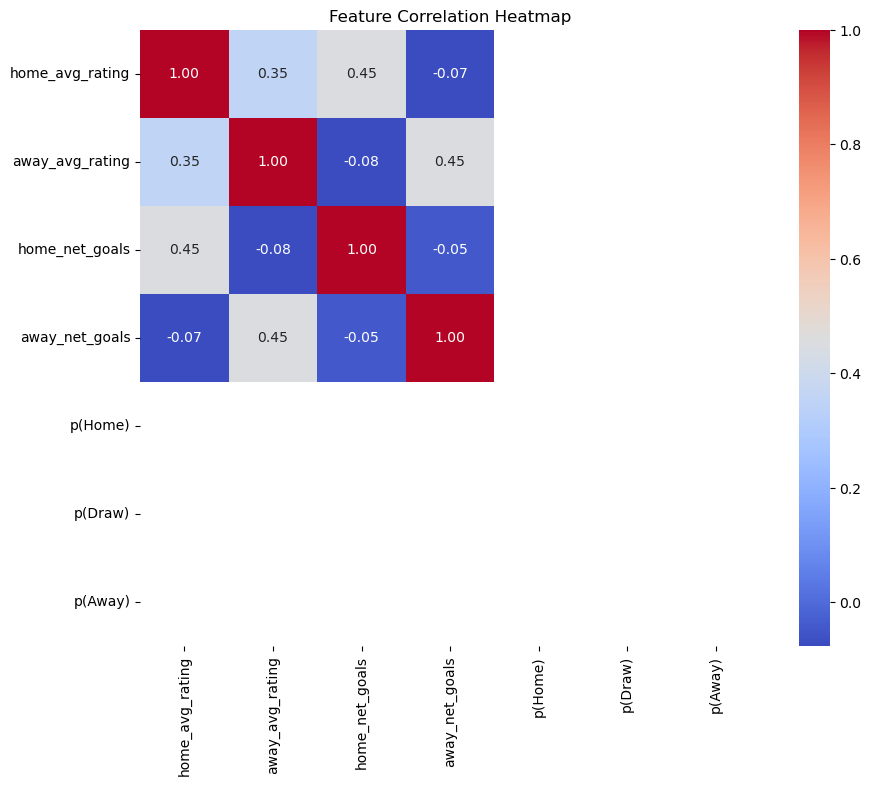

In [734]:
# Calculate correlation matrix
correlation_matrix = pd.DataFrame(X_scaled, columns=features).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


### Why does home_avg_rating correlate with away_avg_rating? - Structural Symmetry

There are some sensible correlations here like away average rating and away net goals being 0.45 correlated.

But notice that the home net goals and home avg rating is also 0.45 - is it a coincidence?

What about the fact that home_avg_rating and away_avg_rating are 0.35 correlated? On face value, this is saying that better teams means are more likely to play each other. This doesn't make sense in the Premier League format where every team must play every other team twice every season... **home and away.**

In this data, every team appears as the home team and the away team an equal number of times (every team plays 19 home games and 19 away games every season) so there is a natural symmetry in the away and home team data at the highest level.

So we should be mindful of symmetry in this dataset, this is a correlation but the rating of the away team and the home team are conceptually distinct.

## PCA examining importance of columns

In [ ]:
# Perform PCA
pca = PCA(n_components=len(features))  # Use all components initially
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Loadings (feature contributions to components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features))], index=features)

# Display loadings
print(loadings)

Explained Variance Ratio: [0.39543185 0.35263257 0.18155194 0.07038364 0.         0.
 0.        ]
                      PC1       PC2       PC3       PC4  PC5  PC6  PC7
home_avg_rating  0.604808 -0.403218 -0.365201 -0.581593  0.0  0.0  0.0
away_avg_rating  0.606158  0.400860 -0.365248  0.581789  0.0  0.0  0.0
home_net_goals   0.363125 -0.583810  0.603996  0.403106  0.0  0.0  0.0
away_net_goals   0.367314  0.579562  0.606969 -0.400969  0.0  0.0  0.0
p(Home)          0.000000  0.000000  0.000000 -0.000000  0.0  0.0  1.0
p(Draw)          0.000000  0.000000  0.000000 -0.000000  0.0  1.0  0.0
p(Away)          0.000000  0.000000  0.000000 -0.000000  1.0  0.0  0.0


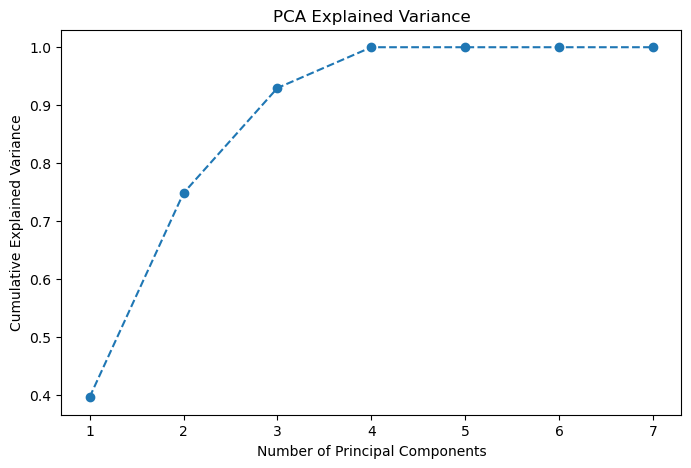

In [737]:
# visualizing the PCA results

# Cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(features) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()


### Analysis of PCA Results / Loadings

1. PC1 is very highly loaded onto the home and away team average ratings, almost identially so, as well to the home and away goals - again, almost identically so.
    - This is because of the structural symmetry identified before. PC1 captures 40% (0.395) of the variance in the feature set, which is heavily influenced by the team's rating, and it applies equally to the home and away team.

2. PC2 is symmetrical but is now distinguishing between the home and the away teams. PC2 captures 35% (0.352) of the data variance. Essentially, the home vs away team comparison.
    - We are being told that the rating and net goals of a team, *as it moves in the other direction of the opposition*, captures a lot of variance

3. PC3 is dominated by net goals, suggesting the performance specific variance that doesn't depend on the team's average rating

**With 3 principal components we have explained around 91% of the variance in the data set.** The prior probabilities p(home), p(away) and p(draw) are disregartded by PCA because they're constants that do not provide any variance to the dataset, but they are still important to the classification.

**IMPORTANT:** This is not explaining the variance in Results, it's variance in the dataset minus the results because PCA did not see the Result column. This is capturing overall variance in this data set. However, high variance features tend to be predictive and PCA has identified these, which we could use in our model or take learnings from the loadings of PC1, 2 and 3 and engineer our own.

The Principal Components here are representations of the original data columns and their variance. If we include them, we don't need to keep the home_avg_rating, home_net_goals and away equivalents. This *might* make the model perform better in classification tasks, but we will lose interpretability. There is also the risk that PCA is prioritizing variance in features that aren't predictive of the result, which is a lose-lose: less interpretability, and a weaker model.

Ideally we have both interpretability and good model performance and we can keep the interpretability by feature engineering information that PCA revealed was important, such as the differential between net goals of the home and away team, and the differential of the team's overall ratings. 

If the performance here is poor, we can fall back on PC1, 2 and 3 and make another model. PCA is still valuable for supervised learning because it has guided our feature engineering here, and has allowed us to go from four features (home/away_avg_rating/net_goals) to two features (**rating_diff and net_goals_diff**).

#### **The advantage of this feature engineering is that the zero-sum nature of matches allow a natural mean/equality of 0 and any positive values indicate favour for the home team, and any negative indivates away team favour.**



## Next Steps for building the model

1. Manual Run with feature engineering differential columns (and prior probabilities), using a logistic regression algorithm. We will create these features and save the csv for model building in another workbook.

2. PCA run with PC1-3 and prior probabilities using another algorithm (possibly random forest?). We'll add the PCA columns and save a separate csv for this separate model building in another workbook.

### 1. Manual Run - saved and model built on *logistic_reg_prem.ipynb*

In [738]:
# Feature engineering the differentials columns

# Step 1: Feature Engineering
prem['rating_diff'] = prem['home_avg_rating'] - prem['away_avg_rating']
prem['net_goals_diff'] = prem['home_net_goals'] - prem['away_net_goals']

In [740]:
prem.sample(5)

,home_avg_rating,home_net_goals,away_avg_rating,away_net_goals,Result,p(Home),p(Draw),p(Away),rating_diff,net_goals_diff
2671,67.4,-0.42,61.6,-0.12,-1,0.457,0.258,0.285,5.8,-0.30
1161,74.3,-0.42,57.4,-0.61,1,0.457,0.258,0.285,16.9,0.19
764,78.5,0.64,74.0,0.83,0,0.457,0.258,0.285,4.5,-0.19
2759,61.6,0.40,60.3,-0.61,1,0.457,0.258,0.285,1.3,1.01
1596,66.6,-0.35,70.1,0.98,-1,0.457,0.258,0.285,-3.5,-1.33


Rather than drop the old columns we'll create a manual_run_df and just not include them there.

In [742]:
# Create the "manual run" DataFrame
manual_run_prem = prem[['rating_diff', 'net_goals_diff', 'p(Home)', 'p(Draw)', 'p(Away)', 'Result']]

In [744]:
manual_run_prem.sample(7)

,rating_diff,net_goals_diff,p(Home),p(Draw),p(Away),Result
277,-0.2,-0.05,0.457,0.258,0.285,0
2847,3.3,-0.40,0.457,0.258,0.285,0
1592,-1.6,-0.13,0.457,0.258,0.285,1
2995,2.5,-0.03,0.457,0.258,0.285,1
1361,-4.1,-0.78,0.457,0.258,0.285,-1
1638,-5.6,0.09,0.457,0.258,0.285,1
172,-8.6,-1.20,0.457,0.258,0.285,-1


### 2. PCA Run - Saved and model built on *random_forest_prem.ipynb*

We will:
1. run PCA on the four columns of important as identified in the first PCA with the larger dataframe
2. concatenate those PCs to the dataframe
3. export to csv and build another model (likely random forest) in another workbook

In [749]:
# PCA setup
pca_cols = ['home_avg_rating', 'away_avg_rating', 'home_net_goals', 'away_net_goals']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(prem[pca_cols])

In [750]:
# Perform PCA on just the four columns from original PCA analysis
pca = PCA(n_components=3)  # Reduce to 3 components - the three PCs that had 91% variance
X_pca = pca.fit_transform(X_scaled)

In [751]:
# add PC1, PC2, PC3 to the dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'], index=prem.index)

In [752]:
pca_run_prem = pd.concat([pca_df, prem[['p(Home)', 'p(Draw)', 'p(Away)', 'Result']]], axis=1)

## Save DataFrames as CSVs to build model in next notebooks

In [753]:
manual_run_prem.to_csv('manual_run_prem.csv', index=False) # index=False to avoid writing the index column
pca_run_prem.to_csv('pca_run_prem.csv', index=False)

Pearson correlation test?

Possibly chi squared test

use clustering to break out the type of matches being played e.g. a tense 0-0 or a goalfest based on the stats